In [1]:
import numpy as np
import pandas as pd
import requests
import json
import datetime
import holidays
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geopandas as gpd
import contextily as ctx



# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://trafikkdata-api.atlas.vegvesen.no/"
# Definerer overskriftene for spørringen inkludert innholdstypen Det er rare kommentarer her siden jeg først tenkte å lage en liten tutorial å sende.
headers = {
    "content-type": "application/json"
}

# Spørringen og endepunktet til API-et må skrives etter hva du vil hente ut i GraphQL format.
apiQuery = """
{
trafficRegistrationPoints(searchQuery: {}) {
    id
    name
    location {
    municipality {
        name
        number
        county{
        name
        }
    }
    coordinates {
        latLon {
        lat
        lon
        }
    }
    }
}
}

"""

# Konverter spørringen til en JSON-streng
payload = json.dumps({
    "query": apiQuery
})

# Gjør en POST-forespørsel til API-et med overskriftene og nyttelasten
response = requests.post(postUrl, headers=headers, data=payload)

# Sjekk om svarstatuskoden er 200 (vellykket)
if response.status_code == 200:
    # Analyser JSON-dataene i svaret
    response_data = response.json()
    # vi må unneste dataen slik at vi får det i kolonner
    df = pd.json_normalize(response_data['data']['trafficRegistrationPoints'])
else:
    # Skriv ut en feilmelding hvis statuskoden ikke er 200
    print(f"Error: {response.status_code}")

#location.municipality.name = Tromsø
df = df[df['location.municipality.name'] == 'Tromsø']
df = df.reset_index(drop=True)
#drop location.municipality.number and name and county
df = df.drop(['location.municipality.number', 'location.municipality.name', 'location.municipality.county.name'], axis=1)
#clean column names from location.coordinates.latLon.lat to lat and location.coordinates.latLon.lon to lon
df.columns = df.columns.str.replace('location.coordinates.latLon.lat', 'lat', regex=False) #setter regex to false siden jeg vil bare skifte nøyaktig det navnet
df.columns = df.columns.str.replace('location.coordinates.latLon.lon', 'lon', regex=False)



# henter trafficRegistrationPointIds fra df
traffic_registration_point_ids = df['id'].tolist()







# Define the start and end datetime objects
start_datetime = datetime.datetime(2018, 1, 1, 23, 0, 0)
end_datetime = datetime.datetime(2024, 6, 1, 23, 0, 0)

# Define the time delta for each iteration
time_delta = datetime.timedelta(hours=100)

# Initialize the list to store the results
all_rows = []

# Loop through the time range and send the requests
while start_datetime < end_datetime:
    # Definerer GraphQL query med "test" for hver trafficRegistrationPointId og setter en new line for hver for å lese i request outputtet om det er rett
    query = """
    {
    """ + "\n".join(
        f"""
    test_{id.replace(':', '_')}: trafficData(trafficRegistrationPointId: "{id}") {{
        volume {{
        byHour(
            from: "{start_datetime.isoformat()}+02:00"
            to: "{(start_datetime + time_delta).isoformat()}+02:00"
        ) {{
            edges {{
            node {{
                from
                to
                byDirection {{
                heading
                total {{
                    volumeNumbers {{
                        volume
                    }}
                    coverage {{
                        percentage
                        }}
                }}
                }}
            }}
            }}
        }}
        }}
    }}
        """
        for id in traffic_registration_point_ids
    ) + "}"
    
    # setter inn link og overskrifter og definerer data for query
    url = "https://trafikkdata-api.atlas.vegvesen.no/"
    headers = {"Content-Type": "application/json"}
    data = {"query": query}

    # Sender requesten og henter resultatet
    response = requests.post(url, headers=headers, json=data)
    result = response.json()

    # henter resultatet fra data som er nestet
    data = result['data']

    # lager en liste of dictionaries, en for hver trafficregistrationpoint. jeg fjerner alias siden jeg ikke trenger det lengere. setter en "if" statement for å fjerne problem om nonetype og legger til 0 istedenfor der det er None
    rows = [    
        {        
            'id': key.replace("test_", ""),        
            'from': item['node']['from'],
            'to': item['node']['to'],
            'heading': heading['heading'],
            'volume': heading['total']['volumeNumbers']['volume'] if heading['total']['volumeNumbers'] is not None else 0,
            'coverage': heading['total']['coverage']['percentage'] if heading['total']['coverage'] is not None else 0
        }
        for key, value in data.items()
        for item in value['volume']['byHour']['edges']
        for heading in item['node']['byDirection']
    ]
    
    # Append the rows to the list of all rows
    all_rows += rows
    
    # Increment the start datetime
    start_datetime += time_delta

# lager et dataframe fra listen av dictionaries
df1 = pd.DataFrame.from_dict(all_rows)





df = df.merge(df1, on='id', how='left')


df.to_csv('Trafikkdata.csv', index=False)



In [84]:
import pandas as pd
import numpy as np
import holidays
import datetime
import statsmodels.api as sm






df = pd.read_csv('Trafikkdata.csv')

df[['from_date', 'from_time']] = df['from'].str.split('T', expand=True)
df[['to_date', 'to_time']] = df['to'].str.split('T', expand=True)

#drop 
df = df.drop(['from', 'to'], axis=1)


#seperate weekdays from weekends
df['from_date'] = pd.to_datetime(df['from_date'])

df = df.dropna(subset=['from_date'])

df['weekday'] = df['from_date'].dt.dayofweek

df['weekday'] = df['weekday'].replace([0, 1, 2, 3, 4], 'weekday')
df['weekday'] = df['weekday'].replace([5, 6], 'weekend')


norwegian_holidays = holidays.country_holidays('NO', years=df['from_date'].dt.year.unique())


df.loc[:, 'holiday'] = df['from_date'].apply(lambda date: date in norwegian_holidays)

df.loc[:, 'weekday'] = np.where(df['holiday'], 'weekend', df['weekday']) #alle ferier blir om til helg
df = df.drop(['holiday'], axis=1)



df = df.drop(df[df['name'] == 'Ryatunnelen'].index) #fjerner Ryatunnelen siden det ligger ute av fokus




#make list of name for Fastlandet
fastlandet = ['FAGERNES SØR', 'FAGERNES NORD', 'FAGERNES ØST', 'Sandvikeidet', 'Rundnes', 'Lunheim', 'HUNGEREN', 'Skjelnan', 'Solstrandvegen Sykkel', 'Tromsøysundvegen Sykkel', 'Kraftforsyningen']
kvaloya = ['Eidvegen', 'Kvaløysletta Sykkel', 'Kvaløysletta nord', 'Kvaløysletta sør', 'Eidkjosen sør', 'KVALSUNDTUNNELEN']
tilkobling = ['Tromsøbrua sykkel', 'Sandnessbrua Sykkel', 'Tromsøysundtunnelen T2', 'Tromsøysundtunnelen T1', 'TROMSØBRUA', 'Sandnessundbrua']
#new column in df for location. ones in kvaloya, fastlandet, tilkobling and rest of tromsøya
df['location'] = np.where(df['name'].isin(fastlandet), 'Fastlandet', np.where(df['name'].isin(kvaloya), 'Kvaløya', np.where(df['name'].isin(tilkobling), 'Tilkoblinger til Tromsøya', 'Tromsøya')))




#One df with only id, name, lat, lon
geotag = df[['id', 'name', 'lat', 'lon']]
geotag = geotag.drop_duplicates(subset=['id'])
geotag = geotag.reset_index(drop=True)

#drop id lat lon from df
df = df.drop(['id', 'lat', 'lon'], axis=1)



#weekday time between 06 and 09 and 15-17 is rush hour, everything else is not rush hour including weekends
df['rush'] = np.where((df['weekday'] == 'weekday') & ((df['from_time'] >= '06:00') & (df['from_time'] <= '09:00') | (df['from_time'] >= '15:00') & (df['from_time'] <= '17:00')), 'rush', 'not rush')

#new col for 2023-01-05 for "bompenger" yes from 05 and no before
df['bompenger'] = np.where(df['from_date'] >= '2023-01-05', '1', '0')




df['from_time'] = pd.to_datetime(df['from_time'], format='%H:%M:%S%z', utc=True).dt.time
df['to_time'] = pd.to_datetime(df['to_time'], format='%H:%M:%S%z', utc=True).dt.time


df['from_time'] = df['from_time'].astype(str)
df['to_time'] = df['to_time'].astype(str)

df['from_time'] = df['from_time'].str.extract(r'(\d{2}:\d{2})') #bare timer og minutter
df['to_time'] = df['to_time'].str.extract(r'(\d{2}:\d{2})')


df['time'] = df['from_time'] + ' - ' + df['to_time']

df = df.drop(['from_time', 'to_time', 'to_date'], axis=1)

df['Vehicle type'] = np.where(df['name'].str.contains('ykkel'), 'bicycle', 'car')

df = df.reset_index(drop=True)



#Converting to daily data as i do not need hourly data now that ive made rushtime and not rushtime.

#group by name, heading, from_date, weekday, rush and sum volume and and take mean of coverage
df = df.groupby(['name', 'heading', 'from_date', 'weekday', 'location', 'rush', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()
#rename from_date to daily
df = df.rename(columns={'from_date': 'daily_data'})


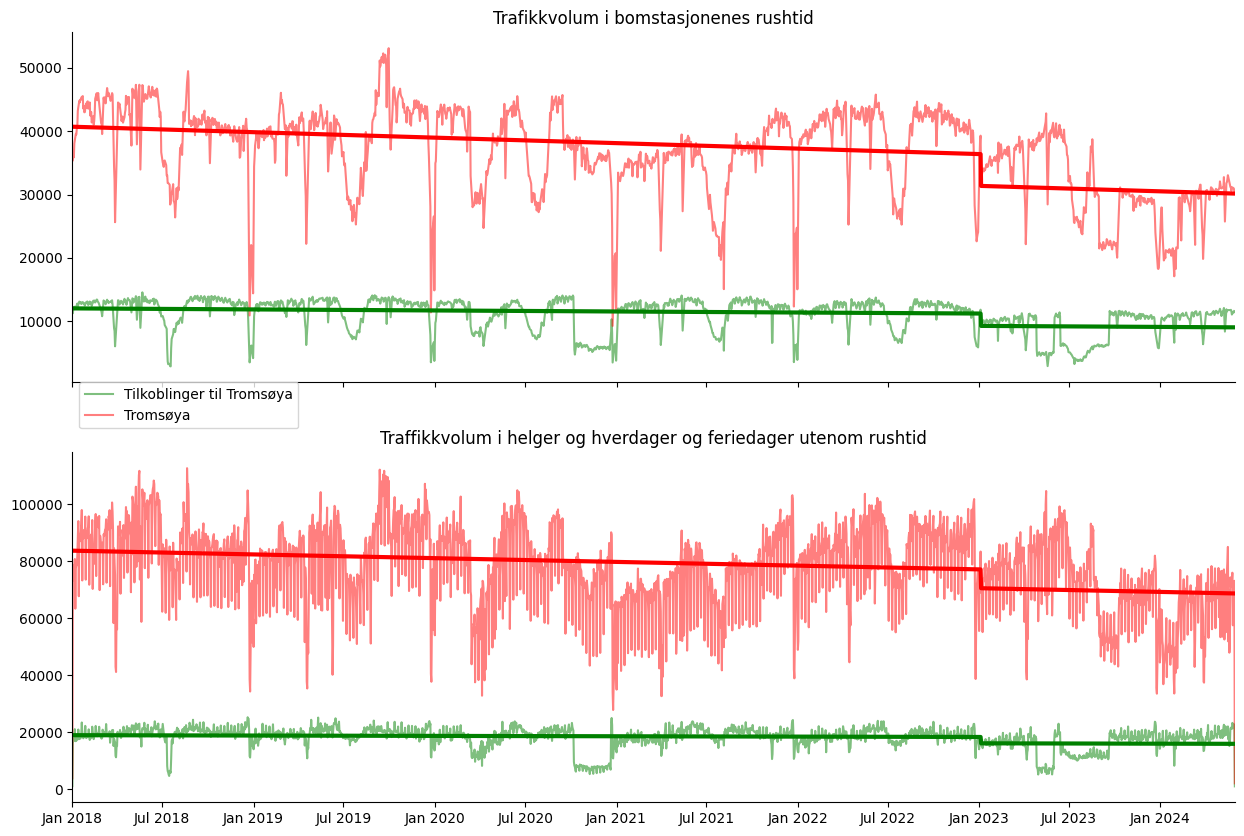

In [91]:

df['daily_data'] = pd.to_datetime(df['daily_data'])
df['month'] = df['daily_data'].dt.month
df['year'] = df['daily_data'].dt.year

location_colors = {
    'Tromsøya': 'red',
    'Fastlandet': 'blue',
    'Kvaløya': '#21130d',
    'Tilkoblinger til Tromsøya': 'green'}



df_historical = df[df['name'].isin(df[(df['daily_data'] == '2018-06-01') | (df['daily_data'] == '2024-04-01')]['name'].unique())]


#only Tromsøya and Tiloblinger til Tromsøya
df_historical = df_historical[df_historical['location'].isin(['Tromsøya', 'Tilkoblinger til Tromsøya'])]

#convert daily_data to object
df_historical['daily_data'] = df_historical['daily_data'].astype(str)
#convert bompenger to int64
df_historical['bompenger'] = df_historical['bompenger'].astype(np.int64)


df_historical = df_historical[df_historical['Vehicle type'] == 'car']
#Har brukt chatgpt

# Merge geotag with df_historical by name
df_historical = df_historical.merge(geotag, on='name', how='left')

# Create a GeoDataFrame from unique locations
unique_locations = df_historical[['name', 'lat', 'lon']].drop_duplicates()

# Separate locations based on the condition
included_locations = unique_locations[unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]
excluded_locations = unique_locations[~unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]


#drop id, lat, lon
df_historical = df_historical.drop(['id', 'lat', 'lon'], axis=1)


#keep only them
df_historical = df_historical[df_historical['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]

#group by daily_data, weekday, rush, location, vehicle type, bompenger and sum volume and and take mean of coverage
df_historical = df_historical.groupby(['daily_data', 'weekday', 'rush', 'location', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()

#weekday
df_historical['daily_data'] = pd.to_datetime(df_historical['daily_data'])


#CHATGPT
#change daily_data to UNIX timestamp (in days)
df_historical['daily_data'] = df_historical['daily_data'].astype(np.int64) // (10**9 * 24 * 3600)
#CHATGPT

#arrange by daily_data
df_historical = df_historical.sort_values(by=['daily_data'])




#two plots with one for rush and one for not rush with lines for each location
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'rush')].plot(x='daily_data', y='volume', label=location, ax=ax, color=location_colors[location], title='Trafikkvolum i bomstasjonenes rushtid', alpha=0.5)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'not rush')].plot(x='daily_data', y='volume', label=location, ax=ax2, color=location_colors[location], title="Traffikkvolum i helger og hverdager og feriedager utenom rushtid", alpha=0.5)



for location in df_historical['location'].unique():
    for rush_value in ['rush', 'not rush']:

        df_historical_subset = df_historical[(df_historical['location'] == location) & (df_historical['rush'] == rush_value)]

        X = df_historical_subset[['daily_data', 'bompenger']]
        y = df_historical_subset['volume']
        X = sm.add_constant(X)

        # Fit the model
        model = sm.OLS(y, X)
        results = model.fit()


        #Plot regression line
        if rush_value == 'rush': #increase thickness of rush lines
            ax.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)
        else:
            ax2.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)


#ChatGPT 
# Get the first day of each month in the daily_data column (converted back to datetime)
unique_dates = pd.date_range(pd.to_datetime(df_historical['daily_data'].min(), unit='D'), pd.to_datetime(df_historical['daily_data'].max(), unit='D'), freq='6MS')

# Convert unique_dates to UNIX timestamp (in days)
unique_dates_unix = (unique_dates.astype(np.int64) // (10**9 * 24 * 3600)).tolist() 
#ChatGPT


#Set xticks for each month
ax.set_xticks(unique_dates_unix)
ax.set_xticklabels(unique_dates.strftime('%b %Y'), rotation=45)

#no space between line and y axis
ax.margins(x=0)
#no x label
ax2.set_xlabel('')

ax.get_legend().set_visible(False)
#spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#ax2 legend between plots
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 1.22), fontsize=10)

ax.tick_params(axis='x', which = 'minor', bottom=False, top=False, labelbottom=True)
ax2.tick_params(axis='x', which = 'minor', bottom=False, top=False, labelbottom=True)


#plt.savefig
plt.savefig('lm_bil_daglig_bompenger.png', bbox_inches='tight', dpi=300)




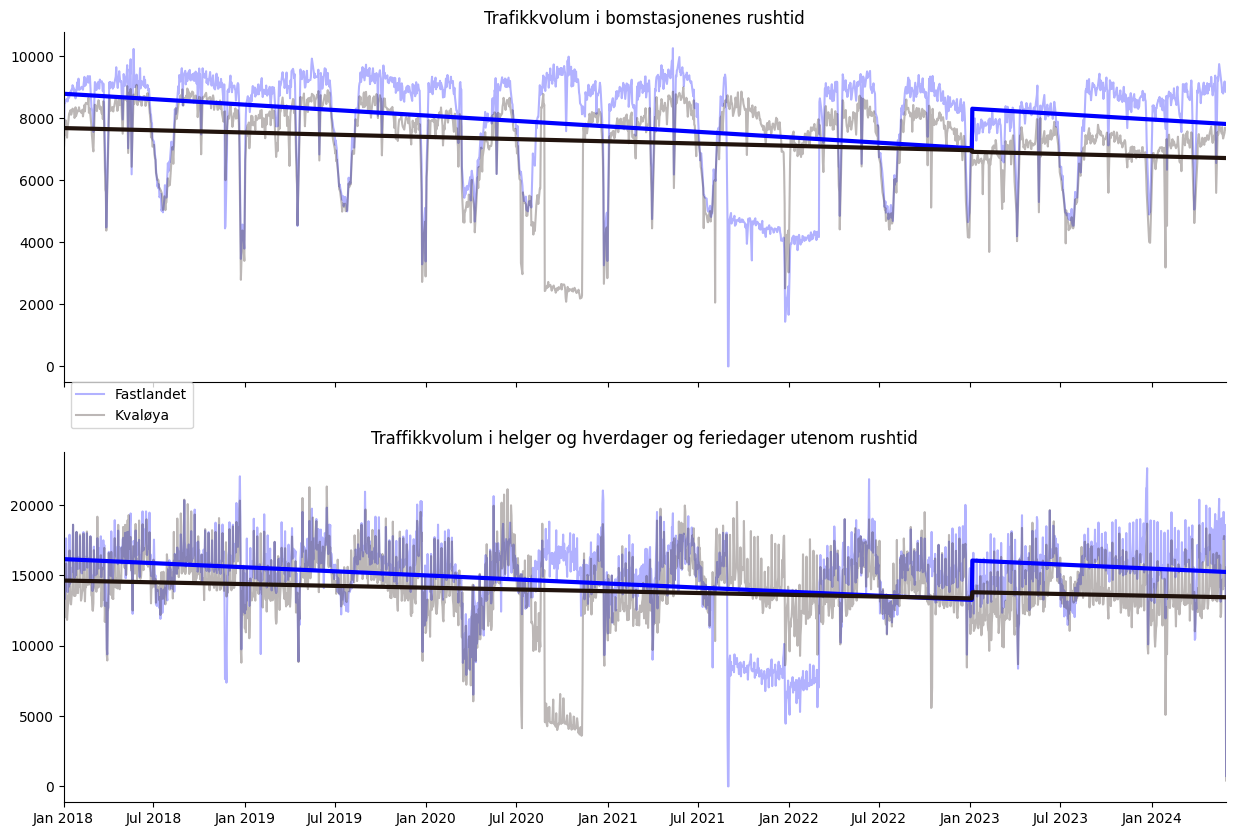

In [93]:
df_historical = df[df['name'].isin(df[(df['daily_data'] == '2018-06-01') | (df['daily_data'] == '2024-04-01')]['name'].unique())]


#not Tromsøya and Tiloblinger til Tromsøya
df_historical = df_historical[~df_historical['location'].isin(['Tromsøya', 'Tilkoblinger til Tromsøya'])]


#convert daily_data to object
df_historical['daily_data'] = df_historical['daily_data'].astype(str)
#convert bompenger to int64
df_historical['bompenger'] = df_historical['bompenger'].astype(np.int64)


df_historical = df_historical[df_historical['Vehicle type'] == 'car']
#Har brukt chatgpt

# Merge geotag with df_historical by name
df_historical = df_historical.merge(geotag, on='name', how='left')

# Create a GeoDataFrame from unique locations
unique_locations = df_historical[['name', 'lat', 'lon']].drop_duplicates()

# Separate locations based on the condition
included_locations = unique_locations[unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]
excluded_locations = unique_locations[~unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]


#drop id, lat, lon
df_historical = df_historical.drop(['id', 'lat', 'lon'], axis=1)


#keep only them
df_historical = df_historical[df_historical['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]

#group by daily_data, weekday, rush, location, vehicle type, bompenger and sum volume and and take mean of coverage
df_historical = df_historical.groupby(['daily_data', 'weekday', 'rush', 'location', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()

#weekday
df_historical['daily_data'] = pd.to_datetime(df_historical['daily_data'])


#CHATGPT
#change daily_data to UNIX timestamp (in days)
df_historical['daily_data'] = df_historical['daily_data'].astype(np.int64) // (10**9 * 24 * 3600)
#CHATGPT

#arrange by daily_data
df_historical = df_historical.sort_values(by=['daily_data'])




#two plots with one for rush and one for not rush with lines for each location
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'rush')].plot(x='daily_data', y='volume', label=location, ax=ax, color=location_colors[location], title='Trafikkvolum i bomstasjonenes rushtid', alpha=0.3)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'not rush')].plot(x='daily_data', y='volume', label=location, ax=ax2, color=location_colors[location], title="Traffikkvolum i helger og hverdager og feriedager utenom rushtid", alpha=0.3)



for location in df_historical['location'].unique():
    for rush_value in ['rush', 'not rush']:

        df_historical_subset = df_historical[(df_historical['location'] == location) & (df_historical['rush'] == rush_value)]

        X = df_historical_subset[['daily_data', 'bompenger']]
        y = df_historical_subset['volume']
        X = sm.add_constant(X)

        # Fit the model
        model = sm.OLS(y, X)
        results = model.fit()


        #Plot regression line
        if rush_value == 'rush': #increase thickness of rush lines
            ax.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)
        else:
            ax2.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)


#ChatGPT 
# Get the first day of each month in the daily_data column (converted back to datetime)
unique_dates = pd.date_range(pd.to_datetime(df_historical['daily_data'].min(), unit='D'), pd.to_datetime(df_historical['daily_data'].max(), unit='D'), freq='6MS')

# Convert unique_dates to UNIX timestamp (in days)
unique_dates_unix = (unique_dates.astype(np.int64) // (10**9 * 24 * 3600)).tolist() 
#ChatGPT


#Set xticks for each month
ax.set_xticks(unique_dates_unix)
ax.set_xticklabels(unique_dates.strftime('%b %Y'), rotation=45)

#no space between line and y axis
ax.margins(x=0)
#no x label
ax2.set_xlabel('')

ax.get_legend().set_visible(False)
#spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#ax2 legend between plots
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 1.22), fontsize=10)

ax.tick_params(axis='x', which = 'minor', bottom=False, top=False, labelbottom=True)
ax2.tick_params(axis='x', which = 'minor', bottom=False, top=False, labelbottom=True)


#plt.savefig
plt.savefig('lm_bil_daglig_bompenger_utenom.png', bbox_inches='tight', dpi=300)




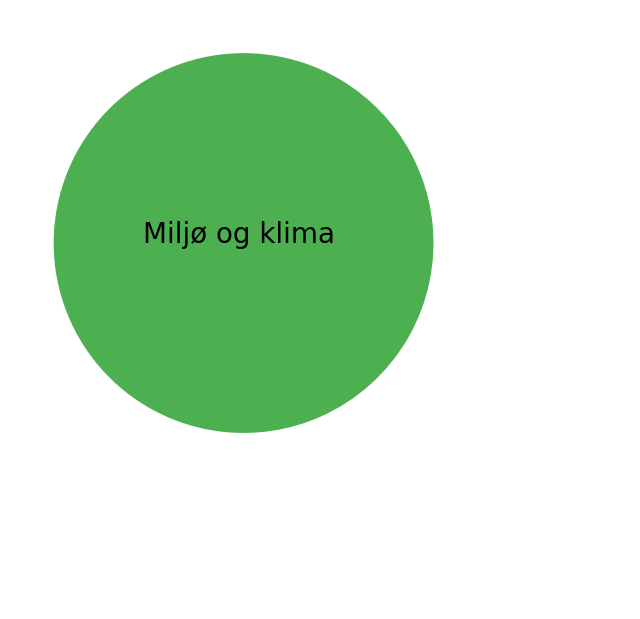

In [5]:
#lets make a venn diagram for bærekraftig utvikling

#Miljø at the bottom left

#Økonomi at the top 

#Sosiale forhold at the bottom right

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
plt.figure(figsize=(8, 8), facecolor="none")
venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=('', '', ''))



# Set the colors
venn.get_label_by_id('100').set_text('')#Miljø og klima
venn.get_label_by_id('001').set_text('') #Økonomisk utvikling
venn.get_label_by_id('010').set_text('') #Sosiale forhold\nSosial tillitt
venn.get_label_by_id('110').set_text('') #Bærekraftig \nsosialt og miljømessig
venn.get_label_by_id('101').set_text('') #Levedyktig
venn.get_label_by_id('011').set_text('') #Rettferdighet
venn.get_label_by_id('111').set_text('') #Bærekraftig utvikling





# Set the alpha for better visibility
for patch in venn.patches:
    patch.set_alpha(0.6)
    patch.set_edgecolor('none')
    patch.set_color('none')

venn.get_patch_by_id('100').set_color('#4CAF50')
venn.get_patch_by_id('101').set_color('#4CAF50')
venn.get_patch_by_id('110').set_color('#4CAF50')
venn.get_patch_by_id('111').set_color('#4CAF50')




venn.get_patch_by_id('100').set_alpha(1)
venn.get_patch_by_id('101').set_alpha(1)
venn.get_patch_by_id('110').set_alpha(1)
venn.get_patch_by_id('111').set_alpha(1)

#text in middle
plt.text(-0.4, 0.1, 'Miljø og klima', color='black', fontsize=20)

plt.savefig('Bærekraftig_utvikling1.png', bbox_inches='tight', dpi=300, transparent=True)

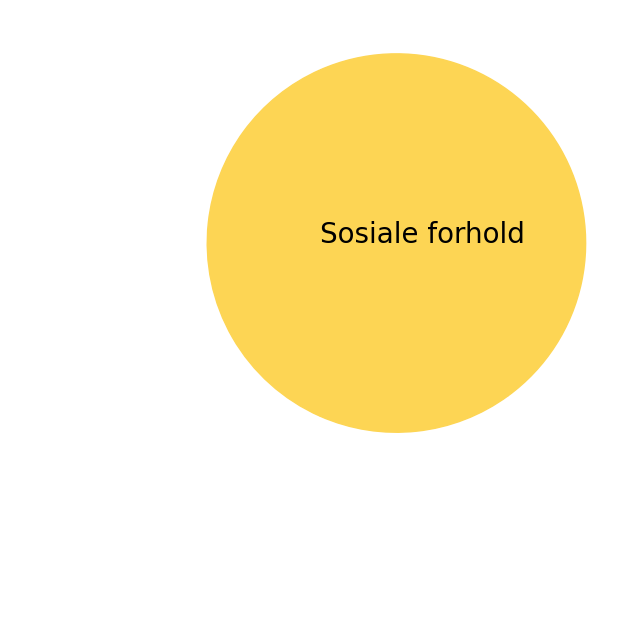

In [6]:
#lets make a venn diagram for bærekraftig utvikling

#Miljø at the bottom left

#Økonomi at the top 

#Sosiale forhold at the bottom right

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
plt.figure(figsize=(8, 8), facecolor="none")
venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=('', '', ''))



# Set the colors
venn.get_label_by_id('100').set_text('') #Miljø og klima
venn.get_label_by_id('001').set_text('') #Økonomisk utvikling
venn.get_label_by_id('010').set_text('') #Sosiale forhold\nSosial tillitt
venn.get_label_by_id('110').set_text('') #Bærekraftig \nsosialt og miljømessig
venn.get_label_by_id('101').set_text('') #Levedyktig
venn.get_label_by_id('011').set_text('') #Rettferdighet
venn.get_label_by_id('111').set_text('') #Bærekraftig utvikling



# Set the alpha for better visibility
for patch in venn.patches:
    patch.set_alpha(0.6)
    patch.set_edgecolor('none')
    patch.set_color('none')




venn.get_patch_by_id('010').set_color('#fdd554')
venn.get_patch_by_id('110').set_color('#fdd554')
venn.get_patch_by_id('011').set_color('#fdd554')
venn.get_patch_by_id('111').set_color('#fdd554')

venn.get_patch_by_id('010').set_alpha(1)
venn.get_patch_by_id('110').set_alpha(1)
venn.get_patch_by_id('011').set_alpha(1)
venn.get_patch_by_id('111').set_alpha(1)

#text in middle
plt.text(0, 0.1, 'Sosiale forhold', color='black', fontsize=20)

plt.savefig('Bærekraftig_utvikling2.png', bbox_inches='tight', dpi=300, transparent=True)

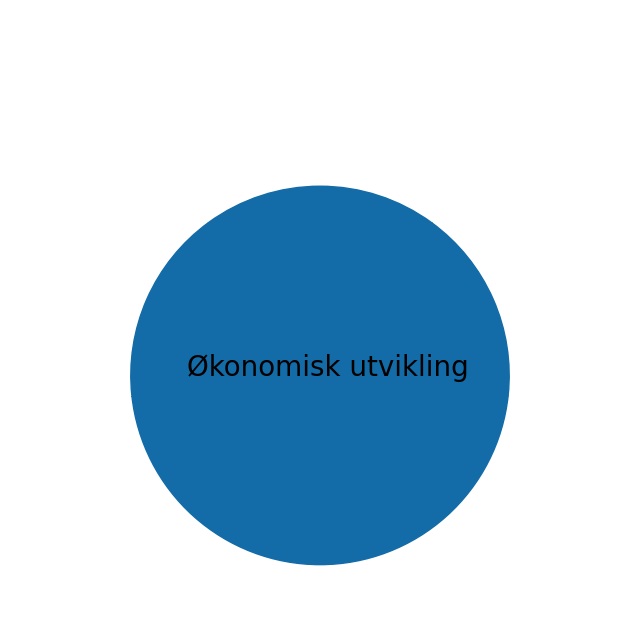

In [7]:
#lets make a venn diagram for bærekraftig utvikling

#Miljø at the bottom left

#Økonomi at the top 

#Sosiale forhold at the bottom right

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
plt.figure(figsize=(8, 8), facecolor="none")
venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=('', '', ''))



# Set the colors
venn.get_label_by_id('100').set_text('') #Miljø og klima
venn.get_label_by_id('001').set_text('') #Økonomisk utvikling
venn.get_label_by_id('010').set_text('') #Sosiale forhold\nSosial tillitt
venn.get_label_by_id('110').set_text('') #Bærekraftig \nsosialt og miljømessig
venn.get_label_by_id('101').set_text('') #Levedyktig
venn.get_label_by_id('011').set_text('') #Rettferdighet
venn.get_label_by_id('111').set_text('') #Bærekraftig utvikling



# Set the alpha for better visibility
for patch in venn.patches:
    patch.set_alpha(0.6)
    patch.set_edgecolor('none')
    patch.set_color('none')




venn.get_patch_by_id('001').set_color('#136ba7')
venn.get_patch_by_id('101').set_color('#136ba7')
venn.get_patch_by_id('011').set_color('#136ba7')
venn.get_patch_by_id('111').set_color('#136ba7')

venn.get_patch_by_id('001').set_alpha(1)
venn.get_patch_by_id('101').set_alpha(1)
venn.get_patch_by_id('011').set_alpha(1)
venn.get_patch_by_id('111').set_alpha(1)

#text in middle
plt.text(-0.3, -0.2, 'Økonomisk utvikling', color='black', fontsize=20)

plt.savefig('Bærekraftig_utvikling3.png', bbox_inches='tight', dpi=300, transparent=True)

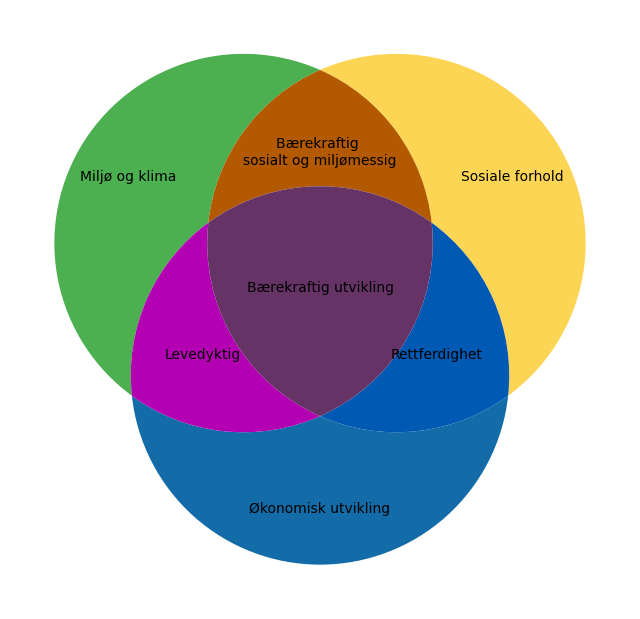

In [8]:
#lets make a venn diagram for bærekraftig utvikling

#Miljø at the bottom left

#Økonomi at the top 

#Sosiale forhold at the bottom right

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
plt.figure(figsize=(8, 8), facecolor="none")
venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=('', '', ''))



# Set the colors
venn.get_label_by_id('100').set_text('Miljø og klima')
venn.get_label_by_id('001').set_text('Økonomisk utvikling')
venn.get_label_by_id('010').set_text('Sosiale forhold')
venn.get_label_by_id('110').set_text('Bærekraftig \nsosialt og miljømessig')
venn.get_label_by_id('101').set_text('Levedyktig')
venn.get_label_by_id('011').set_text('Rettferdighet')
venn.get_label_by_id('111').set_text('Bærekraftig utvikling')


venn.get_patch_by_id('100').set_color('#4CAF50')
venn.get_patch_by_id('001').set_color('#136ba7')
venn.get_patch_by_id('010').set_color('#fdd554')


# Set the alpha for better visibility
for patch in venn.patches:
    patch.set_alpha(1)
    patch.set_edgecolor('none')





plt.savefig('Bærekraftig_utvikling.png', bbox_inches='tight', dpi=300, transparent=True)

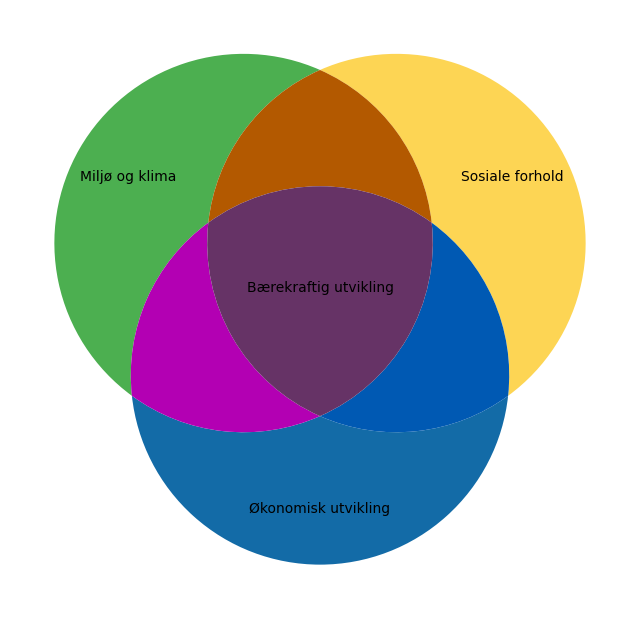

In [4]:
#lets make a venn diagram for bærekraftig utvikling

#Miljø at the bottom left

#Økonomi at the top 

#Sosiale forhold at the bottom right

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
plt.figure(figsize=(8, 8), facecolor="none")
venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=('', '', ''))



# Set the colors
venn.get_label_by_id('100').set_text('Miljø og klima')
venn.get_label_by_id('001').set_text('Økonomisk utvikling')
venn.get_label_by_id('010').set_text('Sosiale forhold')
venn.get_label_by_id('110').set_text('')
venn.get_label_by_id('101').set_text('')
venn.get_label_by_id('011').set_text('')
venn.get_label_by_id('111').set_text('Bærekraftig utvikling')


venn.get_patch_by_id('100').set_color('#4CAF50')
venn.get_patch_by_id('001').set_color('#136ba7')
venn.get_patch_by_id('010').set_color('#fdd554')


# Set the alpha for better visibility
for patch in venn.patches:
    patch.set_alpha(1)
    patch.set_edgecolor('none')





plt.savefig('Bærekraftig_utvikling_tom.png', bbox_inches='tight', dpi=300, transparent=True)

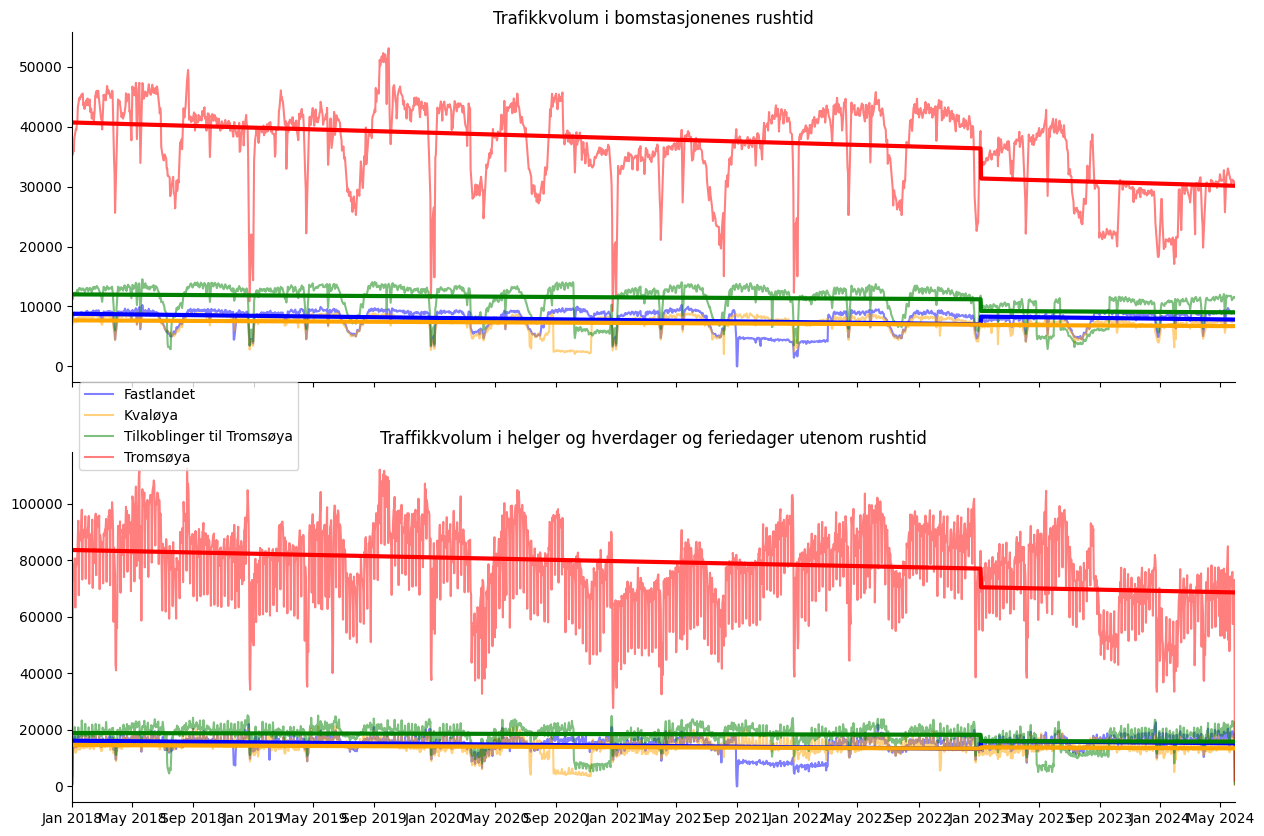

In [74]:
#When working with the data i didnt know that when writing to csv and later reading from csv it changed the dtypes of the columns. Therefor i need the next couple of lines of code.
import statsmodels.api as sm
import geopandas as gpd
import contextily as ctx
df_historical = df.copy()

#convert daily_data to object
df_historical['daily_data'] = df_historical['daily_data'].astype(str)
#convert bompenger to int64
df_historical['bompenger'] = df_historical['bompenger'].astype(np.int64)


df_historical = df_historical[df_historical['Vehicle type'] == 'car']
#Har brukt chatgpt

# Merge geotag with df_historical by name
df_historical = df_historical.merge(geotag, on='name', how='left')

# Create a GeoDataFrame from unique locations
unique_locations = df_historical[['name', 'lat', 'lon']].drop_duplicates()

# Separate locations based on the condition
included_locations = unique_locations[unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]
excluded_locations = unique_locations[~unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]


#drop id, lat, lon
df_historical = df_historical.drop(['id', 'lat', 'lon'], axis=1)


#keep only them
df_historical = df_historical[df_historical['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]

#group by daily_data, weekday, rush, location, vehicle type, bompenger and sum volume and and take mean of coverage
df_historical = df_historical.groupby(['daily_data', 'weekday', 'rush', 'location', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()

#weekday
df_historical['daily_data'] = pd.to_datetime(df_historical['daily_data'])


#CHATGPT
#change daily_data to UNIX timestamp (in days)
df_historical['daily_data'] = df_historical['daily_data'].astype(np.int64) // (10**9 * 24 * 3600)
#CHATGPT

#arrange by daily_data
df_historical = df_historical.sort_values(by=['daily_data'])




#two plots with one for rush and one for not rush with lines for each location
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'rush')].plot(x='daily_data', y='volume', label=location, ax=ax, color=location_colors[location], title='Trafikkvolum i bomstasjonenes rushtid', alpha=0.5)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'not rush')].plot(x='daily_data', y='volume', label=location, ax=ax2, color=location_colors[location], title="Traffikkvolum i helger og hverdager og feriedager utenom rushtid", alpha=0.5)



for location in df_historical['location'].unique():
    for rush_value in ['rush', 'not rush']:

        df_historical_subset = df_historical[(df_historical['location'] == location) & (df_historical['rush'] == rush_value)]

        X = df_historical_subset[['daily_data', 'bompenger']]
        y = df_historical_subset['volume']
        X = sm.add_constant(X)

        # Fit the model
        model = sm.OLS(y, X)
        results = model.fit()


        #Plot regression line
        if rush_value == 'rush': #increase thickness of rush lines
            ax.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)
        else:
            ax2.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)


#ChatGPT 
# Get the first day of each month in the daily_data column (converted back to datetime)
unique_dates = pd.date_range(pd.to_datetime(df_historical['daily_data'].min(), unit='D'), pd.to_datetime(df_historical['daily_data'].max(), unit='D'), freq='4MS')

# Convert unique_dates to UNIX timestamp (in days)
unique_dates_unix = (unique_dates.astype(np.int64) // (10**9 * 24 * 3600)).tolist() 
#ChatGPT


#Set xticks for each month
ax.set_xticks(unique_dates_unix)
ax.set_xticklabels(unique_dates.strftime('%b %Y'), rotation=45)

#no space between line and y axis
ax.margins(x=0)
#no x label
ax2.set_xlabel('')

ax.get_legend().set_visible(False)
#spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#ax2 legend between plots
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 1.22), fontsize=10)

ax.tick_params(axis='x', which = 'minor', bottom=False, top=False, labelbottom=True)
ax2.tick_params(axis='x', which = 'minor', bottom=False, top=False, labelbottom=True)


#plt.savefig
#plt.savefig('lm_bil_daglig_bompenger.png', bbox_inches='tight', dpi=300)

plt.show()



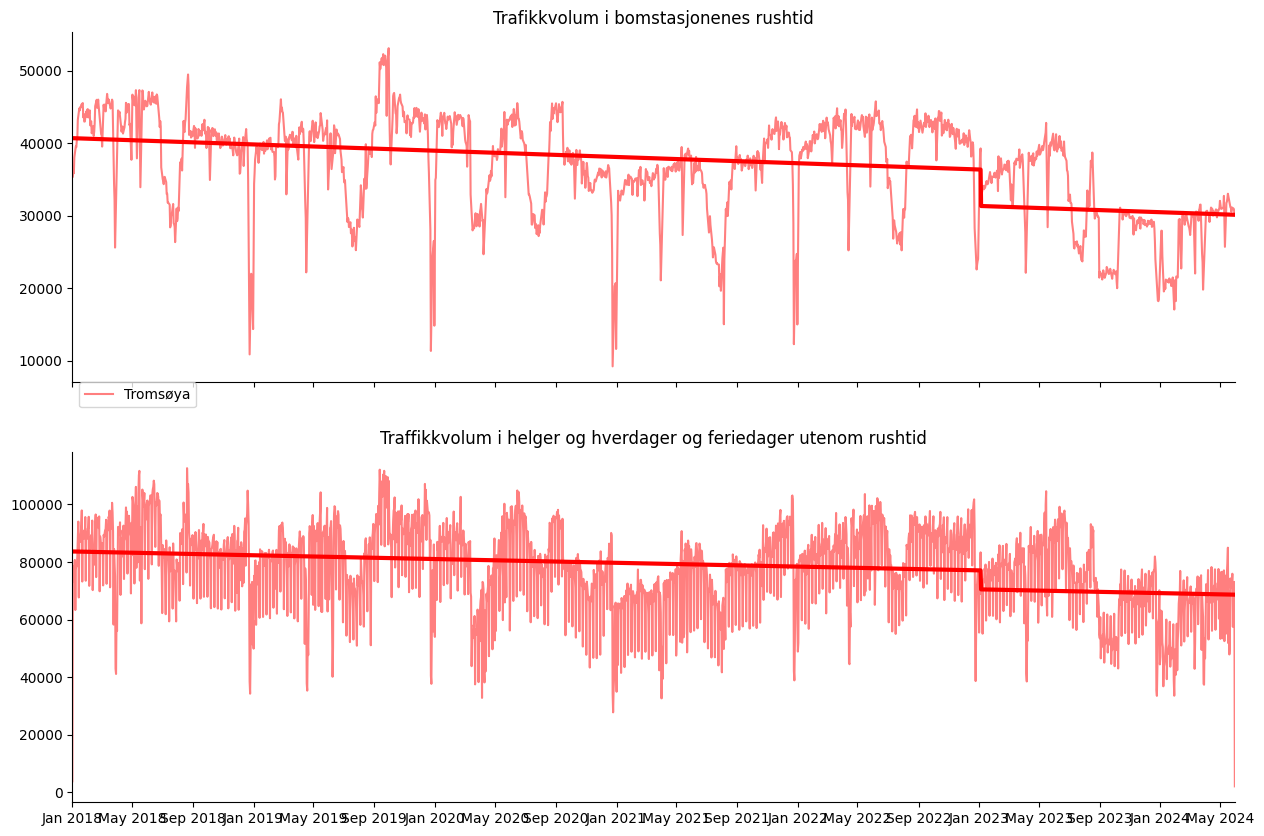

In [86]:
#When working with the data i didnt know that when writing to csv and later reading from csv it changed the dtypes of the columns. Therefor i need the next couple of lines of code.
import statsmodels.api as sm
import geopandas as gpd
import contextily as ctx
df_historical = df.copy()

#removing tromsøya location
df_historical = df_historical[df_historical['location'] == 'Tromsøya']


#convert daily_data to object
df_historical['daily_data'] = df_historical['daily_data'].astype(str)
#convert bompenger to int64
df_historical['bompenger'] = df_historical['bompenger'].astype(np.int64)


df_historical = df_historical[df_historical['Vehicle type'] == 'car']
#Har brukt chatgpt

# Merge geotag with df_historical by name
df_historical = df_historical.merge(geotag, on='name', how='left')

# Create a GeoDataFrame from unique locations
unique_locations = df_historical[['name', 'lat', 'lon']].drop_duplicates()

# Separate locations based on the condition
included_locations = unique_locations[unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]
excluded_locations = unique_locations[~unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]


#drop id, lat, lon
df_historical = df_historical.drop(['id', 'lat', 'lon'], axis=1)


#keep only them
df_historical = df_historical[df_historical['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]

#group by daily_data, weekday, rush, location, vehicle type, bompenger and sum volume and and take mean of coverage
df_historical = df_historical.groupby(['daily_data', 'weekday', 'rush', 'location', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()

#weekday
df_historical['daily_data'] = pd.to_datetime(df_historical['daily_data'])


#CHATGPT
#change daily_data to UNIX timestamp (in days)
df_historical['daily_data'] = df_historical['daily_data'].astype(np.int64) // (10**9 * 24 * 3600)
#CHATGPT

#arrange by daily_data
df_historical = df_historical.sort_values(by=['daily_data'])




#two plots with one for rush and one for not rush with lines for each location
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'rush')].plot(x='daily_data', y='volume', label=location, ax=ax, color=location_colors[location], title='Trafikkvolum i bomstasjonenes rushtid', alpha=0.5)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'not rush')].plot(x='daily_data', y='volume', label=location, ax=ax2, color=location_colors[location], title="Traffikkvolum i helger og hverdager og feriedager utenom rushtid", alpha=0.5)



for location in df_historical['location'].unique():
    for rush_value in ['rush', 'not rush']:

        df_historical_subset = df_historical[(df_historical['location'] == location) & (df_historical['rush'] == rush_value)]

        X = df_historical_subset[['daily_data', 'bompenger']]
        y = df_historical_subset['volume']
        X = sm.add_constant(X)

        # Fit the model
        model = sm.OLS(y, X)
        results = model.fit()


        #Plot regression line
        if rush_value == 'rush': #increase thickness of rush lines
            ax.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)
        else:
            ax2.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)


#ChatGPT 
# Get the first day of each month in the daily_data column (converted back to datetime)
unique_dates = pd.date_range(pd.to_datetime(df_historical['daily_data'].min(), unit='D'), pd.to_datetime(df_historical['daily_data'].max(), unit='D'), freq='4MS')

# Convert unique_dates to UNIX timestamp (in days)
unique_dates_unix = (unique_dates.astype(np.int64) // (10**9 * 24 * 3600)).tolist() 
#ChatGPT


#Set xticks for each month
ax.set_xticks(unique_dates_unix)
ax.set_xticklabels(unique_dates.strftime('%b %Y'), rotation=45)

#no space between line and y axis
ax.margins(x=0)
#no x label
ax2.set_xlabel('')

ax.get_legend().set_visible(False)
#spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#ax2 legend between plots
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 1.22), fontsize=10)

ax.tick_params(axis='x', which = 'minor', bottom=False, top=False, labelbottom=True)
ax2.tick_params(axis='x', which = 'minor', bottom=False, top=False, labelbottom=True)


#plt.savefig
#plt.savefig('lm_bil_daglig_bompenger.png', bbox_inches='tight', dpi=300)

plt.show()



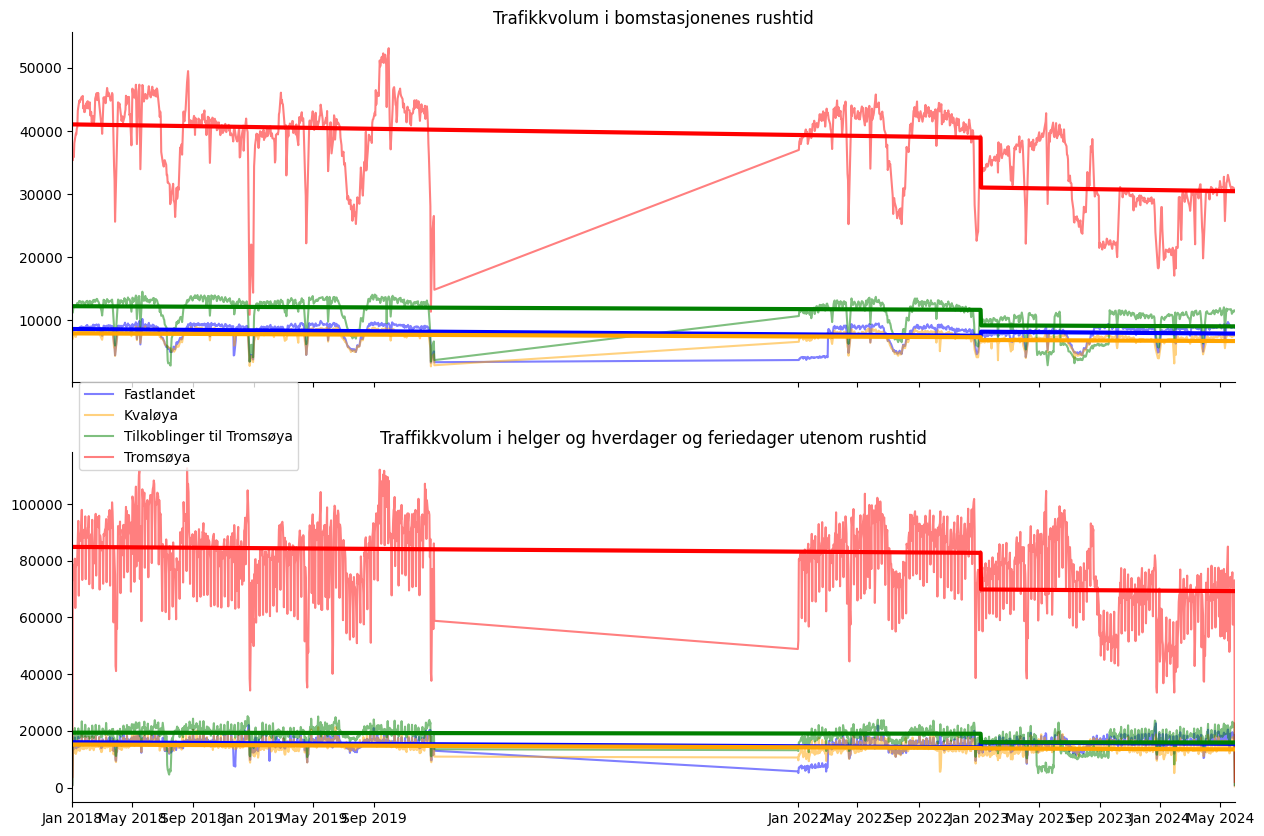

In [83]:
import statsmodels.api as sm
import geopandas as gpd
import contextily as ctx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_historical = df.copy()

# Convert daily_data to object
df_historical['daily_data'] = df_historical['daily_data'].astype(str)
# Convert bompenger to int64
df_historical['bompenger'] = df_historical['bompenger'].astype(np.int64)

df_historical = df_historical[df_historical['Vehicle type'] == 'car']

# Merge geotag with df_historical by name
df_historical = df_historical.merge(geotag, on='name', how='left')

# Create a GeoDataFrame from unique locations
unique_locations = df_historical[['name', 'lat', 'lon']].drop_duplicates()

# Separate locations based on the condition
included_locations = unique_locations[unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]
excluded_locations = unique_locations[~unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]

# Drop id, lat, lon
df_historical = df_historical.drop(['id', 'lat', 'lon'], axis=1)

# Keep only them
df_historical = df_historical[df_historical['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]

# Group by daily_data, weekday, rush, location, vehicle type, bompenger and sum volume and take mean of coverage
df_historical = df_historical.groupby(['daily_data', 'weekday', 'rush', 'location', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()

# Convert daily_data to datetime
df_historical['daily_data'] = pd.to_datetime(df_historical['daily_data'])

# Remove the years 2020 and 2021
df_historical = df_historical[(df_historical['daily_data'].dt.year != 2020) & (df_historical['daily_data'].dt.year != 2021)]

# Change daily_data to UNIX timestamp (in days)
df_historical['daily_data'] = df_historical['daily_data'].astype(np.int64) // (10**9 * 24 * 3600)

# Arrange by daily_data
df_historical = df_historical.sort_values(by=['daily_data'])

# Two plots with one for rush and one for not rush with lines for each location
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'rush')].plot(x='daily_data', y='volume', label=location, ax=ax, color=location_colors[location], title='Trafikkvolum i bomstasjonenes rushtid', alpha=0.5)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'not rush')].plot(x='daily_data', y='volume', label=location, ax=ax2, color=location_colors[location], title="Traffikkvolum i helger og hverdager og feriedager utenom rushtid", alpha=0.5)

for location in df_historical['location'].unique():
    for rush_value in ['rush', 'not rush']:

        df_historical_subset = df_historical[(df_historical['location'] == location) & (df_historical['rush'] == rush_value)]

        X = df_historical_subset[['daily_data', 'bompenger']]
        y = df_historical_subset['volume']
        X = sm.add_constant(X)

        # Fit the model
        model = sm.OLS(y, X)
        results = model.fit()

        # Plot regression line
        if rush_value == 'rush':  # Increase thickness of rush lines
            ax.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)
        else:
            ax2.plot(df_historical_subset['daily_data'], results.fittedvalues, color=location_colors[location], linewidth=3)

# Get the first day of each month in the daily_data column (converted back to datetime)
unique_dates = pd.date_range(pd.to_datetime(df_historical['daily_data'].min(), unit='D'), pd.to_datetime(df_historical['daily_data'].max(), unit='D'), freq='4MS')

# Remove dates from 2020 and 2021
unique_dates = unique_dates[(unique_dates.year != 2020) & (unique_dates.year != 2021)]

# Convert unique_dates to UNIX timestamp (in days)
unique_dates_unix = (unique_dates.astype(np.int64) // (10**9 * 24 * 3600)).tolist()

# Set xticks for each month
ax.set_xticks(unique_dates_unix)
ax.set_xticklabels(unique_dates.strftime('%b %Y'), rotation=45)

# No space between line and y axis
ax.margins(x=0)
# No x label
ax2.set_xlabel('')

ax.get_legend().set_visible(False)
# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# ax2 legend between plots
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 1.22), fontsize=10)

ax.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=True)

# plt.savefig
# plt.savefig('lm_bil_daglig_bompenger.png', bbox_inches='tight', dpi=300)

plt.show()


In [79]:
#looking for year 2021 in df_historical
df_historical

,daily_data,weekday,rush,location,Vehicle type,bompenger,volume,coverage
0,17532,weekend,not rush,Fastlandet,car,0,901.0,50.000000
1,17532,weekend,not rush,Kvaløya,car,0,762.0,100.000000
2,17532,weekend,not rush,Tilkoblinger til Tromsøya,car,0,991.0,100.000000
3,17532,weekend,not rush,Tromsøya,car,0,3754.0,77.777778
4,17533,weekday,not rush,Fastlandet,car,0,14196.0,50.000000
...,...,...,...,...,...,...,...,...
10862,19872,weekday,rush,Tilkoblinger til Tromsøya,car,1,11581.0,100.000000
10865,19873,weekday,not rush,Kvaløya,car,1,414.0,100.000000
10866,19873,weekday,not rush,Tilkoblinger til Tromsøya,car,1,909.0,100.000000
10864,19873,weekday,not rush,Fastlandet,car,1,737.0,100.000000


In [ ]:



#https://contextily.readthedocs.io/en/latest/intro_guide.html#TL;DR Har lest mye her å fikk da hjelp av ChatGPT til å hjelpe meg legge inn verdier og hvordan jeg skulle strukutere kode.
#Her er det brukt ChatGPT for å hjelpe meg med å lage kart. Jeg har spurt den om å bruke Geopandas og contextily for å lage kartet ved bruk av lat og lon i datasettet og jeg har modifisert dette ganske mye.

#chatgpt
# Create GeoDataFrames
gdf_included = gpd.GeoDataFrame(included_locations, geometry=gpd.points_from_xy(included_locations['lon'], included_locations['lat']))
gdf_excluded = gpd.GeoDataFrame(excluded_locations, geometry=gpd.points_from_xy(excluded_locations['lon'], excluded_locations['lat']))

# Set the CRS (Coordinate Reference System) to WGS84
gdf_included.crs = 'epsg:4326'
gdf_excluded.crs = 'epsg:4326'

# Reproject to Web Mercator
gdf_included = gdf_included.to_crs(epsg=3857)
gdf_excluded = gdf_excluded.to_crs(epsg=3857)
#chatgpt

fig, ax = plt.subplots(figsize=(10, 10))

#markers for 2018 og etter
gdf_included.plot(ax=ax, markersize=50, color='red', alpha=0.7, label="2018")
gdf_excluded.plot(ax=ax, markersize=50, color='blue', alpha=0.7, label="lagt til etter 2018")


#chatgpt
# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
#chatgpt


# Set axis limits to zoom in on the area of interest
#setter x og y limit for å kunne ha kartet sentrert på Tromsø og jeg endrer på zoom for å få det til å se bra ut
ax.set_xlim(gdf_excluded.geometry.x.min() - 2500, gdf_excluded.geometry.x.max() + 2500)
ax.set_ylim(gdf_excluded.geometry.y.min() - 2500, gdf_excluded.geometry.y.max() + 2500)


#drop all spines
ax.axis('off')
#drop labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.7), fontsize=15)

#plt savefig
plt.savefig('kart.png', dpi=300);

In [54]:
import holidays
#test = df.copy()

test = pd.read_csv('Trafikkdata.csv')

test[['from_date', 'from_time']] = test['from'].str.split('T', expand=True)
test[['to_date', 'to_time']] = test['to'].str.split('T', expand=True)
test = test.drop(['from', 'to'], axis=1)
#seperate weekdays from weekends
test['from_date'] = pd.to_datetime(test['from_date'])
test = test.dropna(subset=['from_date'])
test['weekday'] = test['from_date'].dt.dayofweek

test['weekday'] = test['weekday'].replace([0, 1, 2, 3, 4], 'weekday')
test['weekday'] = test['weekday'].replace([5, 6], 'weekend')


norwegian_holidays = holidays.country_holidays('NO', years=test['from_date'].dt.year.unique())


test.loc[:, 'holiday'] = test['from_date'].apply(lambda date: date in norwegian_holidays)

test.loc[:, 'weekday'] = np.where(test['holiday'], 'weekend', test['weekday'])
test = test.drop(['holiday'], axis=1)


test = test.drop(test[test['name'] == 'Ryatunnelen'].index) #fjerner Ryatunnelen siden det ligger ute av fokus






#make list of name for Fastlandet
fastlandet = ['FAGERNES SØR', 'FAGERNES NORD', 'FAGERNES ØST', 'Sandvikeidet', 'Rundnes', 'Lunheim', 'HUNGEREN', 'Skjelnan', 'Solstrandvegen Sykkel', 'Tromsøysundvegen Sykkel', 'Kraftforsyningen']
kvaloya = ['Eidvegen', 'Kvaløysletta Sykkel', 'Kvaløysletta nord', 'Kvaløysletta sør', 'Eidkjosen sør', 'KVALSUNDTUNNELEN']
tilkobling = ['Tromsøbrua sykkel', 'Sandnessbrua Sykkel', 'Tromsøysundtunnelen T2', 'Tromsøysundtunnelen T1', 'TROMSØBRUA', 'Sandnessundbrua']
#new column in df for location. ones in kvaloya, fastlandet, tilkobling and rest of tromsøya
test['location'] = np.where(test['name'].isin(fastlandet), 'Fastlandet', np.where(test['name'].isin(kvaloya), 'Kvaløya', np.where(test['name'].isin(tilkobling), 'Tilkoblinger til Tromsøya', 'Tromsøya')))




#One df with only id, name, lat, lon
geotag = test[['id', 'name', 'lat', 'lon']]
geotag = geotag.drop_duplicates(subset=['id'])
geotag = geotag.reset_index(drop=True)

#drop id lat lon from df
test = test.drop(['id', 'lat', 'lon'], axis=1)

test['rush'] = np.where((test['weekday'] == 'weekday') & ((test['from_time'] >= '06:00') & (test['from_time'] <= '09:00') | (test['from_time'] >= '15:00') & (test['from_time'] <= '17:00')), 'rush', 'not rush')

#new col for 2023-01-05 for "bompenger" yes from 05 and no before
test['bompenger'] = np.where(test['from_date'] >= '2023-01-05', '1', '0')



test['from_time'] = pd.to_datetime(test['from_time'], format='%H:%M:%S%z', utc=True).dt.time
test['to_time'] = pd.to_datetime(test['to_time'], format='%H:%M:%S%z', utc=True).dt.time


test['from_time'] = test['from_time'].astype(str)
test['to_time'] = test['to_time'].astype(str)

test['from_time'] = test['from_time'].str.extract(r'(\d{2}:\d{2})') #bare timer og minutter
test['to_time'] = test['to_time'].str.extract(r'(\d{2}:\d{2})')


test['time'] = test['from_time'] + ' - ' + test['to_time']

test = test.drop(['from_time', 'to_time', 'to_date'], axis=1)


test['Vehicle type'] = np.where(test['name'].str.contains('ykkel'), 'bicycle', 'car')

test = test.reset_index(drop=True)


df = df.reset_index(drop=True)



test = test.groupby(['name', 'heading', 'from_date', 'weekday', 'location', 'rush', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()
#rename from_date to daily
test = test.rename(columns={'from_date': 'daily_data'})



test

,name,heading,volume,coverage,from_date,from_time,to_date,to_time,weekday,location,rush,bompenger
0,Eidkjosen sør,Eidkjosen,0.0,0.00,2018-12-13,10:00:00+01:00,2018-12-13,11:00:00+01:00,weekday,Kvaløya,not rush,0
1,Eidkjosen sør,Håkøybotn,0.0,0.00,2018-12-13,10:00:00+01:00,2018-12-13,11:00:00+01:00,weekday,Kvaløya,not rush,0
2,Eidkjosen sør,Eidkjosen,0.0,0.00,2018-12-13,11:00:00+01:00,2018-12-13,12:00:00+01:00,weekday,Kvaløya,not rush,0
3,Eidkjosen sør,Håkøybotn,0.0,0.00,2018-12-13,11:00:00+01:00,2018-12-13,12:00:00+01:00,weekday,Kvaløya,not rush,0
4,Eidkjosen sør,Eidkjosen,0.0,0.00,2018-12-13,12:00:00+01:00,2018-12-13,13:00:00+01:00,weekday,Kvaløya,not rush,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3617699,Stakkevollvegen v/ Kræmer,Hansjordnesbukta,8.0,100.00,2020-12-01,04:00:00+01:00,2020-12-01,05:00:00+01:00,weekday,Tromsøya,not rush,0
3617700,Stakkevollvegen v/ Kræmer,Breivika,11.0,68.33,2020-12-01,05:00:00+01:00,2020-12-01,06:00:00+01:00,weekday,Tromsøya,not rush,0
3617701,Stakkevollvegen v/ Kræmer,Hansjordnesbukta,17.0,68.33,2020-12-01,05:00:00+01:00,2020-12-01,06:00:00+01:00,weekday,Tromsøya,not rush,0
3617702,Stakkevollvegen v/ Kræmer,Breivika,2.0,1.67,2020-12-01,06:00:00+01:00,2020-12-01,07:00:00+01:00,weekday,Tromsøya,rush,0


In [ ]:




df = df.reset_index(drop=True)



#Converting to daily data as i do not need hourly data now that ive made rushtime and not rushtime.

#group by name, heading, from_date, weekday, rush and sum volume and and take mean of coverage
df = df.groupby(['name', 'heading', 'from_date', 'weekday', 'location', 'rush', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()
#rename from_date to daily
df = df.rename(columns={'from_date': 'daily_data'})


#Lager en dictionary for farger slik at jeg er konsistent med fargebruk for Tromsøya, Fastlandet, Kvaløya og bruene og tunnellene.
location_colors = {
    'Tromsøya': 'red',
    'Fastlandet': 'blue',
    'Kvaløya': 'orange',
    'Tilkoblinger til Tromsøya': 'green'}



In [68]:
test = test.groupby(['name', 'heading', 'from_date', 'weekday', 'location', 'rush', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()
#rename from_date to daily
test = test.rename(columns={'from_date': 'daily_data'})

test

,name,heading,daily_data,weekday,location,rush,Vehicle type,bompenger,volume,coverage
0,Breivika,Breivikatunnelen,2018-01-01,weekend,Tromsøya,not rush,car,0,365.0,100.000000
1,Breivika,Breivikatunnelen,2018-01-02,weekday,Tromsøya,not rush,car,0,8216.0,99.952632
2,Breivika,Breivikatunnelen,2018-01-02,weekday,Tromsøya,rush,car,0,4046.0,100.000000
3,Breivika,Breivikatunnelen,2018-01-03,weekday,Tromsøya,not rush,car,0,7969.0,99.922105
4,Breivika,Breivikatunnelen,2018-01-03,weekday,Tromsøya,rush,car,0,4254.0,100.000000
...,...,...,...,...,...,...,...,...,...,...
245219,UIT/Planetariet Sykkel,UNN,2024-05-28,weekday,Tromsøya,not rush,bicycle,1,15.0,100.000000
245220,UIT/Planetariet Sykkel,UNN,2024-05-28,weekday,Tromsøya,rush,bicycle,1,21.0,100.000000
245221,UIT/Planetariet Sykkel,UNN,2024-05-29,weekday,Tromsøya,not rush,bicycle,1,20.0,100.000000
245222,UIT/Planetariet Sykkel,UNN,2024-05-29,weekday,Tromsøya,rush,bicycle,1,15.0,100.000000


In [21]:
#eidkjosen sør
test[test['name'] == 'Eidkjosen sør']
#looking at when holiday is true
test[test['holiday'] == True] 

,name,heading,volume,coverage,from_date,from_time,to_date,to_time,weekday,holiday,location


In [69]:




df = pd.read_csv('Trafikkdata.csv')

df[['from_date', 'from_time']] = df['from'].str.split('T', expand=True)
df[['to_date', 'to_time']] = df['to'].str.split('T', expand=True)

#drop 
df = df.drop(['from', 'to'], axis=1)


#seperate weekdays from weekends
df['from_date'] = pd.to_datetime(df['from_date'])

df = df.dropna(subset=['from_date'])

df['weekday'] = df['from_date'].dt.dayofweek

df['weekday'] = df['weekday'].replace([0, 1, 2, 3, 4], 'weekday')
df['weekday'] = df['weekday'].replace([5, 6], 'weekend')


norwegian_holidays = holidays.country_holidays('NO', years=df['from_date'].dt.year.unique())


df.loc[:, 'holiday'] = df['from_date'].apply(lambda date: date in norwegian_holidays)

df.loc[:, 'weekday'] = np.where(df['holiday'], 'weekend', df['weekday']) #alle ferier blir om til helg
df = df.drop(['holiday'], axis=1)



df = df.drop(df[df['name'] == 'Ryatunnelen'].index) #fjerner Ryatunnelen siden det ligger ute av fokus




#make list of name for Fastlandet
fastlandet = ['FAGERNES SØR', 'FAGERNES NORD', 'FAGERNES ØST', 'Sandvikeidet', 'Rundnes', 'Lunheim', 'HUNGEREN', 'Skjelnan', 'Solstrandvegen Sykkel', 'Tromsøysundvegen Sykkel', 'Kraftforsyningen']
kvaloya = ['Eidvegen', 'Kvaløysletta Sykkel', 'Kvaløysletta nord', 'Kvaløysletta sør', 'Eidkjosen sør', 'KVALSUNDTUNNELEN']
tilkobling = ['Tromsøbrua sykkel', 'Sandnessbrua Sykkel', 'Tromsøysundtunnelen T2', 'Tromsøysundtunnelen T1', 'TROMSØBRUA', 'Sandnessundbrua']
#new column in df for location. ones in kvaloya, fastlandet, tilkobling and rest of tromsøya
df['location'] = np.where(df['name'].isin(fastlandet), 'Fastlandet', np.where(df['name'].isin(kvaloya), 'Kvaløya', np.where(df['name'].isin(tilkobling), 'Tilkoblinger til Tromsøya', 'Tromsøya')))




#One df with only id, name, lat, lon
geotag = df[['id', 'name', 'lat', 'lon']]
geotag = geotag.drop_duplicates(subset=['id'])
geotag = geotag.reset_index(drop=True)

#drop id lat lon from df
df = df.drop(['id', 'lat', 'lon'], axis=1)



#weekday time between 06 and 09 and 15-17 is rush hour, everything else is not rush hour including weekends
df['rush'] = np.where((df['weekday'] == 'weekday') & ((df['from_time'] >= '06:00') & (df['from_time'] <= '09:00') | (df['from_time'] >= '15:00') & (df['from_time'] <= '17:00')), 'rush', 'not rush')

#new col for 2023-01-05 for "bompenger" yes from 05 and no before
df['bompenger'] = np.where(df['from_date'] >= '2023-01-05', '1', '0')




df['from_time'] = pd.to_datetime(df['from_time'], format='%H:%M:%S%z', utc=True).dt.time
df['to_time'] = pd.to_datetime(df['to_time'], format='%H:%M:%S%z', utc=True).dt.time


df['from_time'] = df['from_time'].astype(str)
df['to_time'] = df['to_time'].astype(str)

df['from_time'] = df['from_time'].str.extract(r'(\d{2}:\d{2})') #bare timer og minutter
df['to_time'] = df['to_time'].str.extract(r'(\d{2}:\d{2})')


df['time'] = df['from_time'] + ' - ' + df['to_time']

df = df.drop(['from_time', 'to_time', 'to_date'], axis=1)

df['Vehicle type'] = np.where(df['name'].str.contains('ykkel'), 'bicycle', 'car')

df = df.reset_index(drop=True)



#Converting to daily data as i do not need hourly data now that ive made rushtime and not rushtime.

#group by name, heading, from_date, weekday, rush and sum volume and and take mean of coverage
df = df.groupby(['name', 'heading', 'from_date', 'weekday', 'location', 'rush', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()
#rename from_date to daily
df = df.rename(columns={'from_date': 'daily_data'})


df

,name,heading,daily_data,weekday,location,rush,Vehicle type,bompenger,volume,coverage
0,Breivika,Breivikatunnelen,2018-01-01,weekend,Tromsøya,not rush,car,0,365.0,100.000000
1,Breivika,Breivikatunnelen,2018-01-02,weekday,Tromsøya,not rush,car,0,8216.0,99.952632
2,Breivika,Breivikatunnelen,2018-01-02,weekday,Tromsøya,rush,car,0,4046.0,100.000000
3,Breivika,Breivikatunnelen,2018-01-03,weekday,Tromsøya,not rush,car,0,7969.0,99.922105
4,Breivika,Breivikatunnelen,2018-01-03,weekday,Tromsøya,rush,car,0,4254.0,100.000000
...,...,...,...,...,...,...,...,...,...,...
245219,UIT/Planetariet Sykkel,UNN,2024-05-28,weekday,Tromsøya,not rush,bicycle,1,15.0,100.000000
245220,UIT/Planetariet Sykkel,UNN,2024-05-28,weekday,Tromsøya,rush,bicycle,1,21.0,100.000000
245221,UIT/Planetariet Sykkel,UNN,2024-05-29,weekday,Tromsøya,not rush,bicycle,1,20.0,100.000000
245222,UIT/Planetariet Sykkel,UNN,2024-05-29,weekday,Tromsøya,rush,bicycle,1,15.0,100.000000


In [5]:











#Adding vehicle type since i have one column that contains both car and bicycle. found out later that there are some values that dont use capital letter and some do so ykkel it is.
df['Vehicle type'] = np.where(df['name'].str.contains('ykkel'), 'bicycle', 'car')

#drop rows with NA
df = df.dropna()




df = df.reset_index(drop=True)



#Converting to daily data as i do not need hourly data now that ive made rushtime and not rushtime.

#group by name, heading, from_date, weekday, rush and sum volume and and take mean of coverage
df = df.groupby(['name', 'heading', 'from_date', 'weekday', 'location', 'rush', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()
#rename from_date to daily
df = df.rename(columns={'from_date': 'daily_data'})


#Lager en dictionary for farger slik at jeg er konsistent med fargebruk for Tromsøya, Fastlandet, Kvaløya og bruene og tunnellene.
location_colors = {
    'Tromsøya': 'red',
    'Fastlandet': 'blue',
    'Kvaløya': 'orange',
    'Tilkoblinger til Tromsøya': 'green'}


,id,name,lat,lon,from,to,heading,volume,coverage
0,92719V1125906,Eidkjosen sør,69.673681,18.744357,2018-12-13T10:00:00+01:00,2018-12-13T11:00:00+01:00,Eidkjosen,0.0,0.0
1,92719V1125906,Eidkjosen sør,69.673681,18.744357,2018-12-13T10:00:00+01:00,2018-12-13T11:00:00+01:00,Håkøybotn,0.0,0.0
2,92719V1125906,Eidkjosen sør,69.673681,18.744357,2018-12-13T11:00:00+01:00,2018-12-13T12:00:00+01:00,Eidkjosen,0.0,0.0
3,92719V1125906,Eidkjosen sør,69.673681,18.744357,2018-12-13T11:00:00+01:00,2018-12-13T12:00:00+01:00,Håkøybotn,0.0,0.0
4,92719V1125906,Eidkjosen sør,69.673681,18.744357,2018-12-13T12:00:00+01:00,2018-12-13T13:00:00+01:00,Eidkjosen,0.0,0.0
...,...,...,...,...,...,...,...,...,...
92653,92719V1125906,Eidkjosen sør,69.673681,18.744357,2024-05-30T03:00:00+02:00,2024-05-30T04:00:00+02:00,Håkøybotn,3.0,100.0
92654,92719V1125906,Eidkjosen sør,69.673681,18.744357,2024-05-30T04:00:00+02:00,2024-05-30T05:00:00+02:00,Eidkjosen,2.0,100.0
92655,92719V1125906,Eidkjosen sør,69.673681,18.744357,2024-05-30T04:00:00+02:00,2024-05-30T05:00:00+02:00,Håkøybotn,1.0,100.0
92656,92719V1125906,Eidkjosen sør,69.673681,18.744357,2024-05-30T05:00:00+02:00,2024-05-30T06:00:00+02:00,Eidkjosen,32.0,100.0


MemoryError: Unable to allocate 5.79 GiB for an array with shape (2, 388814820) and data type float64

,id,name,lat,lon
0,92719V1125906,Eidkjosen sør,69.673681,18.744357
1,68511V2673383,Tromsøysundtunnelen T1,69.670120,19.018382
2,52576V1126026,Gimle,69.683548,18.998967
3,31157V2782679,Tromsøysundtunnelen T2,69.670087,19.019226
4,14843V1125937,Giæverbukta nord,69.672391,18.917582
5,79743V1125914,Tromsøbrua,69.654124,18.965350
6,85147V1201967,Hungeren,69.635616,18.961609
7,80998V1125915,Hansjordnestunnelen,69.657871,18.956873
8,02636V1125920,Sandnessundbrua,69.683995,18.905659
9,05293V1125916,Breiviktunnelen,69.659465,18.955189


In [8]:
df1

,id,from,to,heading,volume,coverage
0,68511V2673383,2018-01-01T22:00:00+01:00,2018-01-01T23:00:00+01:00,Tomasjord,141,100.0
1,68511V2673383,2018-01-01T22:00:00+01:00,2018-01-01T23:00:00+01:00,Tromsøya,0,100.0
2,68511V2673383,2018-01-01T23:00:00+01:00,2018-01-02T00:00:00+01:00,Tomasjord,68,100.0
3,68511V2673383,2018-01-01T23:00:00+01:00,2018-01-02T00:00:00+01:00,Tromsøya,0,100.0
4,68511V2673383,2018-01-02T00:00:00+01:00,2018-01-02T01:00:00+01:00,Tomasjord,33,100.0
...,...,...,...,...,...,...
3616101,49212V1126027,2024-05-29T06:00:00+02:00,2024-05-29T07:00:00+02:00,LANGNESBAKKEN,125,100.0
3616102,49212V1126027,2024-05-29T07:00:00+02:00,2024-05-29T08:00:00+02:00,GIÆVERBUKTA,439,100.0
3616103,49212V1126027,2024-05-29T07:00:00+02:00,2024-05-29T08:00:00+02:00,LANGNESBAKKEN,389,100.0
3616104,49212V1126027,2024-05-29T08:00:00+02:00,2024-05-29T09:00:00+02:00,GIÆVERBUKTA,497,100.0


In [10]:
#looking at name Tromsøysundtunnellen T1
df[df['name'] == 'Tromsøysundtunnelen T1']

,id,name,lat,lon,from,to,heading,volume,coverage
1,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-01T22:00:00+01:00,2018-01-01T23:00:00+01:00,Tomasjord,141.0,100.00
2,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-01T22:00:00+01:00,2018-01-01T23:00:00+01:00,Tromsøya,0.0,100.00
3,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-01T23:00:00+01:00,2018-01-02T00:00:00+01:00,Tomasjord,68.0,100.00
4,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-01T23:00:00+01:00,2018-01-02T00:00:00+01:00,Tromsøya,0.0,100.00
5,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-02T00:00:00+01:00,2018-01-02T01:00:00+01:00,Tomasjord,33.0,100.00
...,...,...,...,...,...,...,...,...,...
196,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-05T23:00:00+01:00,2018-01-06T00:00:00+01:00,Tromsøya,0.0,99.38
197,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-06T00:00:00+01:00,2018-01-06T01:00:00+01:00,Tomasjord,45.0,100.00
198,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-06T00:00:00+01:00,2018-01-06T01:00:00+01:00,Tromsøya,0.0,100.00
199,68511V2673383,Tromsøysundtunnelen T1,69.67012,19.018382,2018-01-06T01:00:00+01:00,2018-01-06T02:00:00+01:00,Tomasjord,24.0,100.00


In [ ]:

# Define the start and end datetime objects
start_datetime = datetime.datetime(2018, 1, 1, 23, 0, 0)
end_datetime = datetime.datetime(2024, 6, 1, 23, 0, 0)

# Define the time delta for each iteration
time_delta = datetime.timedelta(hours=100)

# Initialize the list to store the results
all_rows = []

# Loop through the time range and send the requests
while start_datetime < end_datetime:
    # Definerer GraphQL query med "test" for hver trafficRegistrationPointId og setter en new line for hver for å lese i request outputtet om det er rett
    query = """
    {
    """ + "\n".join(
        f"""
    test_{id.replace(':', '_')}: trafficData(trafficRegistrationPointId: "{id}") {{
        volume {{
        byHour(
            from: "{start_datetime.isoformat()}+02:00"
            to: "{(start_datetime + time_delta).isoformat()}+02:00"
        ) {{
            edges {{
            node {{
                from
                to
                byDirection {{
                heading
                total {{
                    volumeNumbers {{
                        volume
                    }}
                    coverage {{
                        percentage
                        }}
                }}
                }}
            }}
            }}
        }}
        }}
    }}
        """
        for id in traffic_registration_point_ids
    ) + "}"
    
    # setter inn link og overskrifter og definerer data for query
    url = "https://trafikkdata-api.atlas.vegvesen.no/"
    headers = {"Content-Type": "application/json"}
    data = {"query": query}

    # Sender requesten og henter resultatet
    response = requests.post(url, headers=headers, json=data)
    result = response.json()

    # henter resultatet fra data som er nestet
    data = result['data']

    # lager en liste of dictionaries, en for hver trafficregistrationpoint. jeg fjerner alias siden jeg ikke trenger det lengere. setter en "if" statement for å fjerne problem om nonetype og legger til 0 istedenfor der det er None
    rows = [    
        {        
            'id': key.replace("test_", ""),        
            'from': item['node']['from'],
            'to': item['node']['to'],
            'heading': heading['heading'],
            'volume': heading['total']['volumeNumbers']['volume'] if heading['total']['volumeNumbers'] is not None else 0,
            'coverage': heading['total']['coverage']['percentage'] if heading['total']['coverage'] is not None else 0
        }
        for key, value in data.items()
        for item in value['volume']['byHour']['edges']
        for heading in item['node']['byDirection']
    ]
    
    # Append the rows to the list of all rows
    all_rows += rows
    
    # Increment the start datetime
    start_datetime += time_delta

# lager et dataframe fra listen av dictionaries
df1 = pd.DataFrame.from_dict(all_rows)


##

#KOMBINERER


#i merge df og df1
df = df.merge(df1, on='id', how='left')






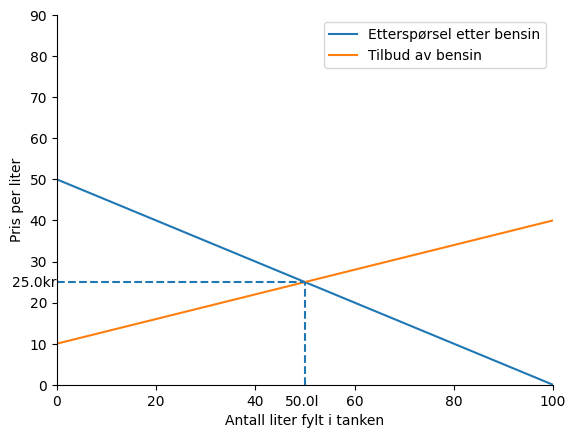

In [127]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt



def demand(p):
    return 50 - 0.5 * p

def supply(p):
    return 10 + 0.3 * p

def eksternaliteter(p):
    return 0.3 * p

p = sp.symbols('p')
intersect = float(sp.solve(demand(p) - supply(p), p)[0])
intersect_y = float(demand(intersect))




x = np.linspace(0, 100, 100)


fig, ax = plt.subplots()

ax.plot(x, demand(x), label='Etterspørsel etter bensin')
ax.plot(x, supply(x), label='Tilbud av bensin')

ax.vlines(intersect, 0, intersect_y, linestyles='dashed')
ax.hlines(intersect_y, 0, intersect, linestyles='dashed')


ax.text(intersect-4, -5, f'{round(intersect,2)}l')
ax.text(-9, intersect_y-1, f'{round(intersect_y,2)}kr')

ax.set_ylim(0, 90)
ax.set_xlim(0, 100)

ax.set_xlabel('Antall liter fylt i tanken')
ax.set_ylabel('Pris per liter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='upper right')


plt.savefig('dødvektstap1.png', bbox_inches='tight', dpi=300)

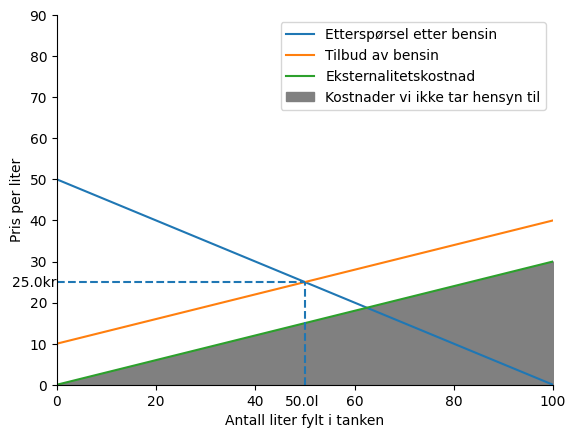

In [128]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt



def demand(p):
    return 50 - 0.5 * p

def supply(p):
    return 10 + 0.3 * p

def eksternaliteter(p):
    return 0.3 * p

p = sp.symbols('p')
intersect = float(sp.solve(demand(p) - supply(p), p)[0])
intersect_y = float(demand(intersect))




x = np.linspace(0, 100, 100)


fig, ax = plt.subplots()

ax.plot(x, demand(x), label='Etterspørsel etter bensin')
ax.plot(x, supply(x), label='Tilbud av bensin')
ax.plot(x, eksternaliteter(x), label='Eksternalitetskostnad')
#fillbetween eksternaliteter and x axis
ax.fill_between(x, eksternaliteter(x), color='gray', label='Kostnader vi ikke tar hensyn til')


ax.vlines(intersect, 0, intersect_y, linestyles='dashed')
ax.hlines(intersect_y, 0, intersect, linestyles='dashed')


ax.text(intersect-4, -5, f'{round(intersect,2)}l')
ax.text(-9, intersect_y-1, f'{round(intersect_y,2)}kr')

ax.set_ylim(0, 90)
ax.set_xlim(0, 100)

ax.set_xlabel('Antall liter fylt i tanken')
ax.set_ylabel('Pris per liter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='upper right')
plt.savefig('dødvektstap2.png', bbox_inches='tight', dpi=300)

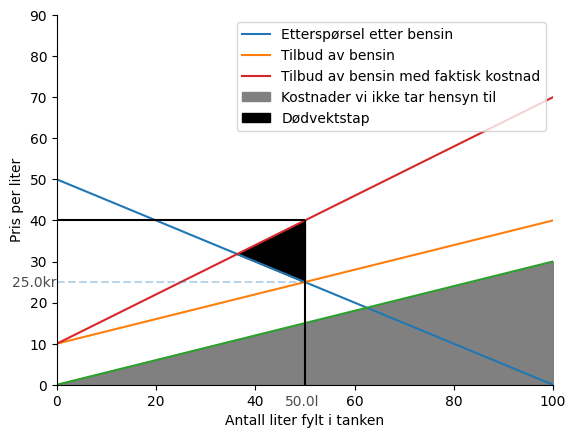

In [129]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt



def demand(p):
    return 50 - 0.5 * p

def supply(p):
    return 10 + 0.3 * p

def eksternaliteter(p):
    return 0.3 * p

p = sp.symbols('p')
intersect = float(sp.solve(demand(p) - supply(p), p)[0])
intersect_y = float(demand(intersect))




x = np.linspace(0, 100, 100)


fig, ax = plt.subplots()

ax.plot(x, demand(x), label='Etterspørsel etter bensin')
ax.plot(x, supply(x), label='Tilbud av bensin')
ax.plot(x, eksternaliteter(x))
#fillbetween eksternaliteter and x axis
#eksternaliteter added onto supply
ax.plot(x, supply(x) + eksternaliteter(x), label='Tilbud av bensin med faktisk kostnad')

ax.fill_between(x, eksternaliteter(x), color='gray', label='Kostnader vi ikke tar hensyn til')



#new intersect
intersect_new = float(sp.solve(demand(p) - (supply(p) + eksternaliteter(p)), p)[0])
intersect_y_new = float(supply(intersect) + eksternaliteter(intersect))

fillbetweenarea = np.linspace(intersect_new, intersect, 100)

#fillbetween intersect_new and intersect
ax.fill_between(fillbetweenarea, supply(fillbetweenarea) + eksternaliteter(fillbetweenarea), demand(fillbetweenarea), color='black', label='Dødvektstap')
ax.vlines(intersect, 0, intersect_y, linestyles='dashed', alpha=0.3)
ax.hlines(intersect_y, 0, intersect, linestyles='dashed', alpha=0.3)

ax.vlines(intersect, 0, intersect_y_new, linestyles='solid', color="black")
ax.hlines(intersect_y_new, 0, intersect, linestyles='solid', color="black")




ax.text(intersect-4, -5, f'{round(intersect,2)}l', alpha=0.7)
ax.text(-9, intersect_y-1, f'{round(intersect_y,2)}kr', alpha=0.7)



ax.set_ylim(0, 90)
ax.set_xlim(0, 100)

ax.set_xlabel('Antall liter fylt i tanken')
ax.set_ylabel('Pris per liter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='upper right')
plt.savefig('dødvektstap3.png', bbox_inches='tight', dpi=300)

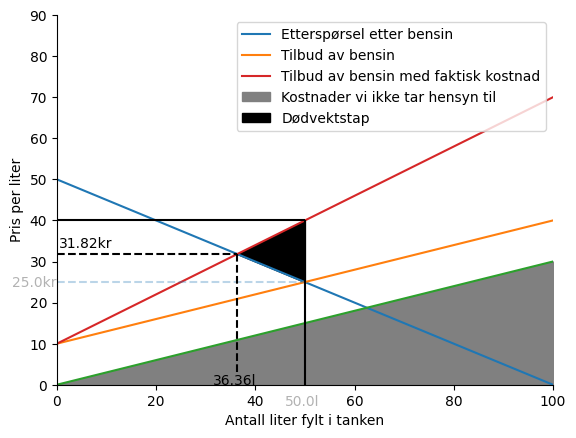

In [130]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt



def demand(p):
    return 50 - 0.5 * p

def supply(p):
    return 10 + 0.3 * p

def eksternaliteter(p):
    return 0.3 * p

p = sp.symbols('p')
intersect = float(sp.solve(demand(p) - supply(p), p)[0])
intersect_y = float(demand(intersect))




x = np.linspace(0, 100, 100)


fig, ax = plt.subplots()

ax.plot(x, demand(x), label='Etterspørsel etter bensin')
ax.plot(x, supply(x), label='Tilbud av bensin')
ax.plot(x, eksternaliteter(x))
#fillbetween eksternaliteter and x axis
#eksternaliteter added onto supply
ax.plot(x, supply(x) + eksternaliteter(x), label='Tilbud av bensin med faktisk kostnad')

ax.fill_between(x, eksternaliteter(x), color='gray', label='Kostnader vi ikke tar hensyn til')



#new intersect
intersect_new = float(sp.solve(demand(p) - (supply(p) + eksternaliteter(p)), p)[0])
intersect_y_new = float(supply(intersect) + eksternaliteter(intersect))

fillbetweenarea = np.linspace(intersect_new, intersect, 100)

#fillbetween intersect_new and intersect
ax.fill_between(fillbetweenarea, supply(fillbetweenarea) + eksternaliteter(fillbetweenarea), demand(fillbetweenarea), color='black', label='Dødvektstap')
ax.vlines(intersect, 0, intersect_y, linestyles='dashed', alpha=0.3)
ax.hlines(intersect_y, 0, intersect, linestyles='dashed', alpha=0.3)

ax.vlines(intersect, 0, intersect_y_new, linestyles='solid', color="black")
ax.hlines(intersect_y_new, 0, intersect, linestyles='solid', color="black")




ax.text(intersect-4, -5, f'{round(intersect,2)}l', alpha=0.3)
ax.text(-9, intersect_y-1, f'{round(intersect_y,2)}kr', alpha=0.3)

ax.vlines(intersect_new, 3, float(supply(intersect_new) + eksternaliteter(intersect_new)), linestyles='dashed', color='black')
ax.text(intersect_new-5, 0, f'{round(intersect_new,2)}l', color='black')

ax.hlines(float(supply(intersect_new) + eksternaliteter(intersect_new)), 0, intersect_new, linestyles='dashed', color='black')
ax.text(0.5, float(supply(intersect_new) + eksternaliteter(intersect_new))+1.5, f'{round(float(supply(intersect_new) + eksternaliteter(intersect_new)),2)}kr', color='black')


ax.set_ylim(0, 90)
ax.set_xlim(0, 100)

ax.set_xlabel('Antall liter fylt i tanken')
ax.set_ylabel('Pris per liter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='upper right')
plt.savefig('dødvektstap4.png', bbox_inches='tight', dpi=300)

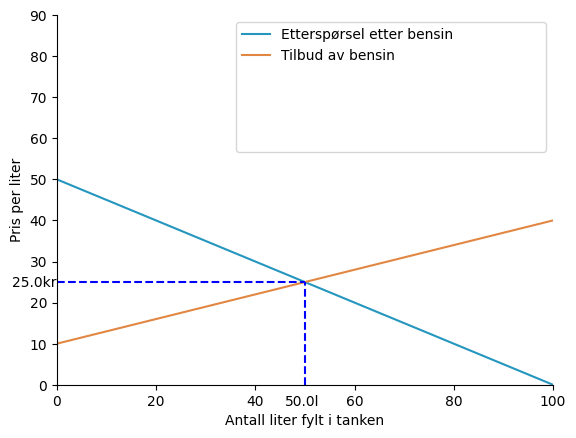

In [202]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt



def demand(p):
    return 50 - 0.5 * p

def supply(p):
    return 10 + 0.3 * p

def eksternaliteter(p):
    return 0.3 * p

p = sp.symbols('p')
intersect = float(sp.solve(demand(p) - supply(p), p)[0])
intersect_y = float(demand(intersect))




x = np.linspace(0, 100, 100)


fig, ax = plt.subplots()

ax.plot(x, demand(x), label='Etterspørsel etter bensin                    ', color="#2596be")
ax.plot(x, supply(x), label='Tilbud av bensin', color="#e28743")
ax.plot(x, eksternaliteter(x), color="none", label=" ")
#fillbetween eksternaliteter and x axis
#eksternaliteter added onto supply
ax.plot(x, supply(x) + eksternaliteter(x), color="none", label=' ')

ax.fill_between(x, eksternaliteter(x), color='none', label=' ')



#new intersect
intersect_new = float(sp.solve(demand(p) - (supply(p) + eksternaliteter(p)), p)[0])
intersect_y_new = float(supply(intersect) + eksternaliteter(intersect))

fillbetweenarea = np.linspace(intersect_new, intersect, 100)

#fillbetween intersect_new and intersect
ax.fill_between(fillbetweenarea, supply(fillbetweenarea) + eksternaliteter(fillbetweenarea), demand(fillbetweenarea), color='none', label=' ')
ax.vlines(intersect, 0, intersect_y, linestyles='dashed', alpha=1, color="blue")
ax.hlines(intersect_y, 0, intersect, linestyles='dashed', alpha=1, color="blue")

ax.vlines(intersect, 0, intersect_y_new, linestyles='solid', color="none")
ax.hlines(intersect_y_new, 0, intersect, linestyles='solid', color="none")




ax.text(intersect-4, -5, f'{round(intersect,2)}l', alpha=1)
ax.text(-9, intersect_y-1, f'{round(intersect_y,2)}kr', alpha=1)

ax.vlines(intersect_new, 3, float(supply(intersect_new) + eksternaliteter(intersect_new)), linestyles='dashed', color='none')
ax.text(intersect_new-5, 0, f'{round(intersect_new,2)}l', color='none')

ax.hlines(float(supply(intersect_new) + eksternaliteter(intersect_new)), 0, intersect_new, linestyles='dashed', color='none')
ax.text(0.5, float(supply(intersect_new) + eksternaliteter(intersect_new))+1.5, f'{round(float(supply(intersect_new) + eksternaliteter(intersect_new)),2)}kr', color='none')


ax.set_ylim(0, 90)
ax.set_xlim(0, 100)

ax.set_xlabel('Antall liter fylt i tanken')
ax.set_ylabel('Pris per liter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='upper right')
plt.savefig('dødvektstap1.png', bbox_inches='tight', dpi=300)

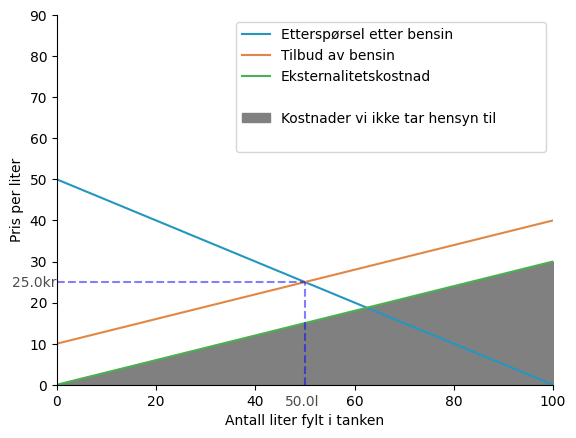

In [203]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt



def demand(p):
    return 50 - 0.5 * p

def supply(p):
    return 10 + 0.3 * p

def eksternaliteter(p):
    return 0.3 * p

p = sp.symbols('p')
intersect = float(sp.solve(demand(p) - supply(p), p)[0])
intersect_y = float(demand(intersect))




x = np.linspace(0, 100, 100)


fig, ax = plt.subplots()

ax.plot(x, demand(x), label='Etterspørsel etter bensin                    ', color="#2596be")
ax.plot(x, supply(x), label='Tilbud av bensin', color="#e28743")
ax.plot(x, eksternaliteter(x), color="#4CAF50", label='Eksternalitetskostnad')
#fillbetween eksternaliteter and x axis
#eksternaliteter added onto supply
ax.plot(x, supply(x) + eksternaliteter(x), color="none", label=' ')

ax.fill_between(x, eksternaliteter(x), color='gray', label='Kostnader vi ikke tar hensyn til')



#new intersect
intersect_new = float(sp.solve(demand(p) - (supply(p) + eksternaliteter(p)), p)[0])
intersect_y_new = float(supply(intersect) + eksternaliteter(intersect))

fillbetweenarea = np.linspace(intersect_new, intersect, 100)

#fillbetween intersect_new and intersect
ax.fill_between(fillbetweenarea, supply(fillbetweenarea) + eksternaliteter(fillbetweenarea), demand(fillbetweenarea), color='none', label=' ')
ax.vlines(intersect, 0, intersect_y, linestyles='dashed', alpha=0.5, color="blue")
ax.hlines(intersect_y, 0, intersect, linestyles='dashed', alpha=0.5, color="blue")

ax.vlines(intersect, 0, intersect_y_new, linestyles='solid', color="none")
ax.hlines(intersect_y_new, 0, intersect, linestyles='solid', color="none")




ax.text(intersect-4, -5, f'{round(intersect,2)}l', alpha=0.7)
ax.text(-9, intersect_y-1, f'{round(intersect_y,2)}kr', alpha=0.7)

ax.vlines(intersect_new, 3, float(supply(intersect_new) + eksternaliteter(intersect_new)), linestyles='dashed', color='none')
ax.text(intersect_new-5, 0, f'{round(intersect_new,2)}l', color='none')

ax.hlines(float(supply(intersect_new) + eksternaliteter(intersect_new)), 0, intersect_new, linestyles='dashed', color='none')
ax.text(0.5, float(supply(intersect_new) + eksternaliteter(intersect_new))+1.5, f'{round(float(supply(intersect_new) + eksternaliteter(intersect_new)),2)}kr', color='none')


ax.set_ylim(0, 90)
ax.set_xlim(0, 100)

ax.set_xlabel('Antall liter fylt i tanken')
ax.set_ylabel('Pris per liter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='upper right')
plt.savefig('dødvektstap2.png', bbox_inches='tight', dpi=300, transparent=True)

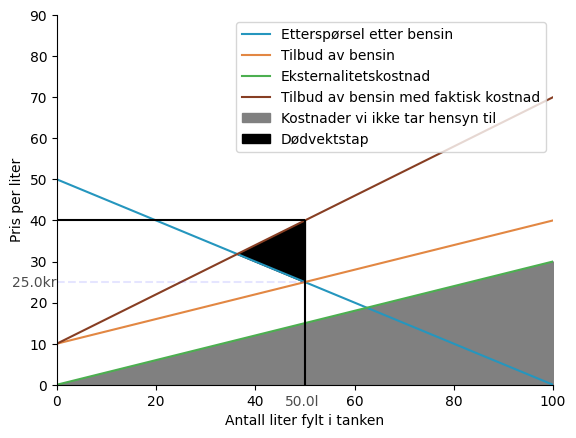

In [204]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt



def demand(p):
    return 50 - 0.5 * p

def supply(p):
    return 10 + 0.3 * p

def eksternaliteter(p):
    return 0.3 * p

p = sp.symbols('p')
intersect = float(sp.solve(demand(p) - supply(p), p)[0])
intersect_y = float(demand(intersect))




x = np.linspace(0, 100, 100)


fig, ax = plt.subplots()

ax.plot(x, demand(x), label='Etterspørsel etter bensin                    ', color="#2596be")
ax.plot(x, supply(x), label='Tilbud av bensin', color="#e28743")
ax.plot(x, eksternaliteter(x), color="#4CAF50", label='Eksternalitetskostnad')
#fillbetween eksternaliteter and x axis
#eksternaliteter added onto supply
ax.plot(x, supply(x) + eksternaliteter(x), color="#873e23", label='Tilbud av bensin med faktisk kostnad')

ax.fill_between(x, eksternaliteter(x), color='gray', label='Kostnader vi ikke tar hensyn til')



#new intersect
intersect_new = float(sp.solve(demand(p) - (supply(p) + eksternaliteter(p)), p)[0])
intersect_y_new = float(supply(intersect) + eksternaliteter(intersect))

fillbetweenarea = np.linspace(intersect_new, intersect, 100)

#fillbetween intersect_new and intersect
ax.fill_between(fillbetweenarea, supply(fillbetweenarea) + eksternaliteter(fillbetweenarea), demand(fillbetweenarea), color='black', label='Dødvektstap')
ax.vlines(intersect, 0, intersect_y, linestyles='dashed', alpha=0.1, color="blue")
ax.hlines(intersect_y, 0, intersect, linestyles='dashed', alpha=0.1, color="blue")

ax.vlines(intersect, 0, intersect_y_new, linestyles='solid', color="black")
ax.hlines(intersect_y_new, 0, intersect, linestyles='solid', color="black")




ax.text(intersect-4, -5, f'{round(intersect,2)}l', alpha=0.7)
ax.text(-9, intersect_y-1, f'{round(intersect_y,2)}kr', alpha=0.7)

ax.vlines(intersect_new, 3, float(supply(intersect_new) + eksternaliteter(intersect_new)), linestyles='dashed', color='none')
ax.text(intersect_new-5, 0, f'{round(intersect_new,2)}l', color='none')

ax.hlines(float(supply(intersect_new) + eksternaliteter(intersect_new)), 0, intersect_new, linestyles='dashed', color='none')
ax.text(0.5, float(supply(intersect_new) + eksternaliteter(intersect_new))+1.5, f'{round(float(supply(intersect_new) + eksternaliteter(intersect_new)),2)}kr', color='none')


ax.set_ylim(0, 90)
ax.set_xlim(0, 100)

ax.set_xlabel('Antall liter fylt i tanken')
ax.set_ylabel('Pris per liter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='upper right')
plt.savefig('dødvektstap3.png', bbox_inches='tight', dpi=300, transparent=True)

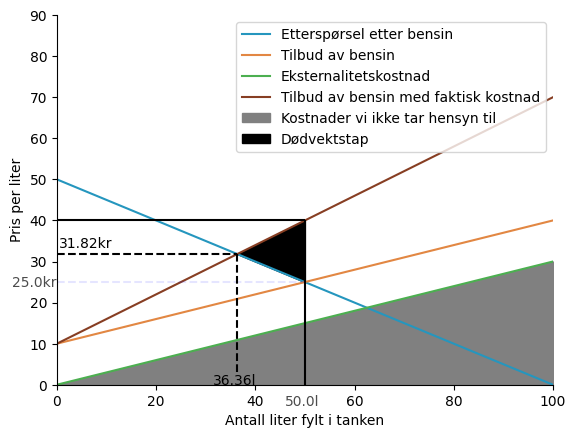

In [205]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt



def demand(p):
    return 50 - 0.5 * p

def supply(p):
    return 10 + 0.3 * p

def eksternaliteter(p):
    return 0.3 * p

p = sp.symbols('p')
intersect = float(sp.solve(demand(p) - supply(p), p)[0])
intersect_y = float(demand(intersect))




x = np.linspace(0, 100, 100)


fig, ax = plt.subplots()

ax.plot(x, demand(x), label='Etterspørsel etter bensin                    ', color="#2596be")
ax.plot(x, supply(x), label='Tilbud av bensin', color="#e28743")
ax.plot(x, eksternaliteter(x), color="#4CAF50", label='Eksternalitetskostnad')
#fillbetween eksternaliteter and x axis
#eksternaliteter added onto supply
ax.plot(x, supply(x) + eksternaliteter(x), color="#873e23", label='Tilbud av bensin med faktisk kostnad')

ax.fill_between(x, eksternaliteter(x), color='gray', label='Kostnader vi ikke tar hensyn til')



#new intersect
intersect_new = float(sp.solve(demand(p) - (supply(p) + eksternaliteter(p)), p)[0])
intersect_y_new = float(supply(intersect) + eksternaliteter(intersect))

fillbetweenarea = np.linspace(intersect_new, intersect, 100)

#fillbetween intersect_new and intersect
ax.fill_between(fillbetweenarea, supply(fillbetweenarea) + eksternaliteter(fillbetweenarea), demand(fillbetweenarea), color='black', label='Dødvektstap')
ax.vlines(intersect, 0, intersect_y, linestyles='dashed', alpha=0.1, color="blue")
ax.hlines(intersect_y, 0, intersect, linestyles='dashed', alpha=0.1, color="blue")

ax.vlines(intersect, 0, intersect_y_new, linestyles='solid', color="black")
ax.hlines(intersect_y_new, 0, intersect, linestyles='solid', color="black")




ax.text(intersect-4, -5, f'{round(intersect,2)}l', alpha=0.7)
ax.text(-9, intersect_y-1, f'{round(intersect_y,2)}kr', alpha=0.7)

ax.vlines(intersect_new, 3, float(supply(intersect_new) + eksternaliteter(intersect_new)), linestyles='dashed', color='black')
ax.text(intersect_new-5, 0, f'{round(intersect_new,2)}l', color='black')

ax.hlines(float(supply(intersect_new) + eksternaliteter(intersect_new)), 0, intersect_new, linestyles='dashed', color='black')
ax.text(0.5, float(supply(intersect_new) + eksternaliteter(intersect_new))+1.5, f'{round(float(supply(intersect_new) + eksternaliteter(intersect_new)),2)}kr', color='black')


ax.set_ylim(0, 90)
ax.set_xlim(0, 100)

ax.set_xlabel('Antall liter fylt i tanken')
ax.set_ylabel('Pris per liter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='upper right')
plt.savefig('dødvektstap4.png', bbox_inches='tight', dpi=300, transparent=True)